<a href="https://colab.research.google.com/github/aledima00/Project4_SemSeg_AML2024/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 4 - Semantic Segmentation

First let's download dataset, that is already split in "Train", "Test" and "Val" modules

## Downloads and General Config

In [1]:
!pip install colorama | tail -n 1
!pip install albumentations | tail -n 1
!pip install yacs | tail -n 1
!pip install fvcore | tail -n 1
!pip install tqdm | tail -n 1


Generic Imports: here we import all generic libraries required from now on; more specific libraries will be imported later.

In [2]:
# miscellaneous
import os
import glob
from enum import Enum
import gdown
import numpy as np

# torch basics
import torch
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# image management
import torchvision
from torchvision import transforms
import albumentations
from PIL import Image

# logging and printing
import logging
from colorama import Fore, Back, Style
from tqdm.auto import tqdm

None # suppress output

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.0 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


General Configuration:

In [3]:
CONFIG_DATASET = True         # set to True to download and config all dataset resources
CONFIG_DEEPLABV2 = True       # set to True to download and config all DeepLabv2 resources
CONFIG_PIDNET = True          # set to True to download and config all PIDNET resources
CONFIG_ADAPTSEGNET = True     # set to True to download and config all AdaptSegNet resources

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {DEVICE}")
TRAIN_PATH = "Train"          # path of the train folder
VAL_PATH = "Val"              # path of the val folder
TEST_PATH = "Test"            # path of the test folder

DEEPLABV2_PRETRAIN_WEIGHTS_PATH = "deeplabv2-pretrain-weights.pth"  # path of the deeplabv2 pretrain weights
PIDNET_PRETRAIN_WEIGHTS_PATH = "PIDNet/pretrained_models/imagenet/imagenet.pth.tar" # path of the PIDNet pretrain weights

############# DEV UTILITY #############
# this part is used to download weights obtained in previous runs
CONFIG_FINAL_WEIGHTS = True   # set to True to download and config all weights obtained in previous runs
MODELS_FOLDER = "saved_models"
def get_final_weights_path(model_name:str):
  return MODELS_FOLDER + "/" + model_name + ".pth"
if not os.path.isdir(MODELS_FOLDER):
    os.makedirs(MODELS_FOLDER)
#######################################


Using device: cuda


function to download datasets:

In [4]:
def config_generic_dataset(DS_PATHNAME,URL):
  !rm -rf {DS_PATHNAME}
  ZIP_PATH = DS_PATHNAME + ".zip"
  !rm {ZIP_PATH}
  !wget -O {ZIP_PATH} {URL}
  !unzip {ZIP_PATH} | tail -n 3
  !rm {ZIP_PATH}

def config_train_dataset():
  config_generic_dataset(TRAIN_PATH, "https://zenodo.org/records/5706578/files/Train.zip?download=1")
def config_val_dataset():
  config_generic_dataset(VAL_PATH, "https://zenodo.org/records/5706578/files/Val.zip?download=1")
def config_test_dataset():
  config_generic_dataset(TEST_PATH, "https://zenodo.org/records/5706578/files/Test.zip?download=1")

def config_all_dataset(*,force=False):
  print("Dowloading and Configuring Dataset")
  if force or (not os.path.exists(TRAIN_PATH)):
    config_train_dataset()
  if force or (not os.path.exists(VAL_PATH)):
    config_val_dataset()
  # if force or (not os.path.exists(TEST_PATH)):
  #   config_test_dataset()

function to download and configure deeplabv2 model library (_with R101 backbone_) and the pretrain weights:

In [5]:
def config_deeplabv2_model():
  print("Dowloading and Configuring DeepLabv2 Model")
  import sys
  import gdown
  !rm -rf "MLDL2024_project1"
  !git clone https://github.com/Gabrysse/MLDL2024_project1.git
  sys.path.append("/content/MLDL2024_project1/")
  gdown.download("https://drive.google.com/uc?id=1ZX0UCXvJwqd2uBGCX7LI2n-DfMg3t74v", DEEPLABV2_PRETRAIN_WEIGHTS_PATH, quiet=False)


function to download and configure pidnet model library and the pretrain weights:

In [6]:
def config_pidnet():
  import sys
  import gdown
  print("Dowloading and Configuring PIDNET Model")
  !rm -rf "PIDNet"
  !git clone https://github.com/XuJiacong/PIDNet.git
  sys.path.append("/content/PIDNet/")
  gdown.download("https://drive.google.com/uc?id=1hIBp_8maRr60-B3PF0NVtaA6TYBvO4y-", PIDNET_PRETRAIN_WEIGHTS_PATH, quiet=False)


function to download adaptsegnet model library and pretrain weights:

In [7]:
def config_adaptsegnet_model():
  print("Dowloading and Configuring AdaptSegNet Model")
  import sys
  import gdown
  !rm -rf "AdaptSegNet"
  !git clone https://github.com/wasidennis/AdaptSegNet.git
  sys.path.append("/content/AdaptSegNet/")

Actual conditional invokations:

In [8]:
if CONFIG_DATASET:
  config_all_dataset()
if CONFIG_DEEPLABV2:
  config_deeplabv2_model()
if CONFIG_PIDNET:
  config_pidnet()
if CONFIG_ADAPTSEGNET:
  config_adaptsegnet_model()

Dowloading and Configuring Dataset
rm: cannot remove 'Train.zip': No such file or directory
--2025-01-14 14:54:22--  https://zenodo.org/records/5706578/files/Train.zip?download=1
Resolving zenodo.org (zenodo.org)... 188.185.45.92, 188.185.48.194, 188.185.43.25, ...
Connecting to zenodo.org (zenodo.org)|188.185.45.92|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4021669263 (3.7G) [application/octet-stream]
Saving to: ‘Train.zip’

Train.zip           100%[===================>]   3.75G  13.0MB/s    in 5m 0s   

2025-01-14 14:59:22 (12.8 MB/s) - ‘Train.zip’ saved [4021669263/4021669263]

  inflating: Train/Urban/masks_png/2519.png  
  inflating: Train/Urban/masks_png/2520.png  
  inflating: Train/Urban/masks_png/2521.png  
rm: cannot remove 'Val.zip': No such file or directory
--2025-01-14 15:00:05--  https://zenodo.org/records/5706578/files/Val.zip?download=1
Resolving zenodo.org (zenodo.org)... 188.185.43.25, 188.185.45.92, 188.185.48.194, ...
Connecting to ze

Downloading...
From (original): https://drive.google.com/uc?id=1ZX0UCXvJwqd2uBGCX7LI2n-DfMg3t74v
From (redirected): https://drive.google.com/uc?id=1ZX0UCXvJwqd2uBGCX7LI2n-DfMg3t74v&confirm=t&uuid=1a377ce0-d2f7-4b90-9649-47a364c774c5
To: /content/deeplabv2-pretrain-weights.pth
100%|██████████| 177M/177M [00:03<00:00, 57.7MB/s]

Dowloading and Configuring PIDNET Model


Cloning into 'PIDNet'...
remote: Enumerating objects: 386, done.
remote: Counting objects: 100% (193/193), done.
remote: Compressing objects: 100% (68/68), done.
remote: Total 386 (delta 131), reused 125 (delta 125), pack-reused 193 (from 1)
Receiving objects: 100% (386/386), 212.80 MiB | 35.69 MiB/s, done.
Resolving deltas: 100% (184/184), done.


Downloading...
From: https://drive.google.com/uc?id=1hIBp_8maRr60-B3PF0NVtaA6TYBvO4y-
To: /content/PIDNet/pretrained_models/imagenet/imagenet.pth.tar
100%|██████████| 38.1M/38.1M [00:00<00:00, 171MB/s]


Dowloading and Configuring AdaptSegNet Model
Cloning into 'AdaptSegNet'...
remote: Enumerating objects: 281, done.
remote: Total 281 (delta 0), reused 0 (delta 0), pack-reused 281 (from 1)
Receiving objects: 100% (281/281), 2.98 MiB | 7.04 MiB/s, done.
Resolving deltas: 100% (146/146), done.


## Data Preparation

Here we want to create the DataSet class and define the interfaces to use it.

First let's define some parameters about data:

In [9]:
NUM_CLASSES = 7
BATCH_SIZE = 16
IMAGENET_MEAN = (0.485, 0.456, 0.406)
IMAGENET_STDDEV = (0.229, 0.224, 0.225)
NUM_WORKERS = 4

we define the transformation to apply on the dataset using albumentations in order to automatically distinguish which transformation must be applied on both images and masks and which others must be applied only on images:

In [10]:
import albumentations as ALB
from albumentations.pytorch import ToTensorV2

# base_transform: used without augmentation for both train and test
base_transform = ALB.Compose([
      ALB.Resize(256,256,),
      ALB.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STDDEV),
      ToTensorV2()
  ],additional_targets={"edge":"mask"})


then we define the `CATEGORY_MAP` used to interpretate the mask representation:

In [11]:
# taken from official repo of LoveDA
IGNORE_INDEX = -1
CATEGORY_MAP = {
    IGNORE_INDEX:"IGNORE",
    0:"Background",
    1:"Building",
    2:"Road",
    3:"Water",
    4:"Barren",
    5:"Forest",
    6:"Agricultural"
}

COLOR_MAP = {
  IGNORE_INDEX: (0,0,0), # BLACK
  0: (150, 150, 150), # GREY
  1: (255, 0, 0), # RED
  2: (0, 255, 0), # GREEN
  3: (0, 0, 255), # BLUE
  4: (255, 255, 0), # YELLOW
  5: (0, 255, 255), # CYAN
  6: (255, 0, 255) # MAGENTA
}

CLASSES = list(key for key in CATEGORY_MAP.keys() if CATEGORY_MAP[key] != "IGNORE")

finally, we can define the `LoveDA` class, used to create dataset instances; in addition, we define:
- `DataType` *enum* class, used to choose what dataset to instantiate;
- `pil_loader` function, to load images and masks

In [12]:
y_k_size = 6
x_k_size = 6

def pil_loader(path,*,format:str="RGB"):
    # open path as file to avoid ResourceWarning (https://github.com/python-pillow/Pillow/issues/835)
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert(format)

class DataType(Enum):
  RURAL = 0
  URBAN = 1

class LoveDA(Dataset):
  def __init__(self, basedir, data_type:DataType, transforms=None,*,with_edges=True,edge_size=4):
    #super(LoveDA, self).__init__(basedir, transforms, target_transform) # should we do this??
    if data_type == DataType.RURAL:
        self.base_path = os.path.join(basedir, "Rural")
    else: #data_type == DataType.URBAN:
        self.base_path = os.path.join(basedir, "Urban")


    # list of integers that identifies paths relative to both images_png and masks_png
    self.int_pathrefs = os.listdir(os.path.join(self.base_path, "images_png"))
    self.int_pathrefs = list(int(st.split(".")[0]) for st in self.int_pathrefs)

    self.transforms = transforms
    self.with_edges = with_edges
    self.edge_size = edge_size

  def __getitem__(self, idx):
    assert idx < len(self), 'Index out of range'
    image_path = os.path.join(self.base_path, "images_png", str(self.int_pathrefs[idx]) + ".png")
    mask_path = os.path.join(self.base_path, "masks_png", str(self.int_pathrefs[idx]) + ".png")
    image = pil_loader(image_path,format="RGB")
    mask = pil_loader(mask_path,format="L")

    # Convert PIL images to numpy arrays
    image = np.array(image)
    mask = np.array(mask, dtype=np.int8)
    if self.with_edges:
      edge = cv2.Canny(mask.astype("uint8"), 0.1, 0.2)
      kernel = np.ones((self.edge_size, self.edge_size), np.uint8)
      edge = edge[y_k_size:-y_k_size, x_k_size:-x_k_size]
      edge = np.pad(edge, ((y_k_size,y_k_size),(x_k_size,x_k_size)), mode='constant')
      edge = (cv2.dilate(edge, kernel, iterations=1)>50)*1.0

    if self.transforms is not None:
      if self.with_edges:
        augmented = self.transforms(image=image, mask=mask, edge=edge)
        edge = augmented["edge"]
      else:
        augmented = self.transforms(image=image, mask=mask)
      image = augmented["image"]
      mask = augmented["mask"]

    mask -= 1

    if self.with_edges:
      return image, mask, edge
    else:
      return image, mask

  def __len__(self):
    return len(self.int_pathrefs)


## Utilities

Now we define some utilities useful for different purposes.

In [13]:
def dbgp(name,value):
  """ Debug print function """
  print(f"{Style.BRIGHT}{Fore.BLACK}{Back.YELLOW}DBGP -- {Back.RED}{name}:\t{value}{Fore.RESET}{Back.RESET}{Style.RESET_ALL}")

#### IoUMeter
First we define the `IoUMeter` class, useful to compute IoU for classes and over the whole set:

In [14]:
EPSILON_IOU = 1e-7

class IoUMeter:
  total_intersection_per_class:dict
  total_union_per_class:dict

  def __init__(self):
    self.total_intersection_per_class = {cls: 0 for cls in CLASSES}
    self.total_union_per_class = {cls: 0 for cls in CLASSES}
  def zero(self):
    self.total_intersection_per_class = {cls: 0 for cls in CLASSES}
    self.total_union_per_class = {cls: 0 for cls in CLASSES}
  def addCouple(self,predicted,labels):
    for cls in CLASSES:
      true_mask = (labels == cls)  # Crea una maschera booleana per la classe `cls` nel target
      pred_mask = (predicted == cls)  # Crea una maschera booleana per la classe `cls` nelle predizioni

      # Calcola l'intersezione e l'unione per quella classe
      intersection = torch.logical_and(true_mask, pred_mask).sum().item()
      union = torch.logical_or(true_mask, pred_mask).sum().item()

      # Aggiungi i valori all'array totale di intersezione e unione per ogni classe
      self.total_intersection_per_class[cls] += intersection
      self.total_union_per_class[cls] += union
  def getPerClass(self):
    return { cls: self.total_intersection_per_class[cls] / (self.total_union_per_class[cls] + EPSILON_IOU) for cls in CLASSES }
  def getTotal(self):
    class_IoUs = self.getPerClass()
    return sum(class_IoUs.values()) / NUM_CLASSES



#### Plotter
Now we define a plotter to shrink lines of code in loops:

In [15]:
class StatPlotMode(Enum):
  TRAINING = 0
  VALIDATION = 1
  TESTING = 2

  def __str__(self):
    return self.name

def stat_plot(avg_loss,iou_meter:IoUMeter,*,mode:StatPlotMode,epoch=None):
  mean_IoU = iou_meter.getTotal()
  if mode==StatPlotMode.TRAINING:
    print(Fore.GREEN + Style.NORMAL + 'TRAINING RESULTS (@epoch={}): mean Loss = {:.3f} | mean-IoU = {:.3f}'.format(epoch + 1, avg_loss, mean_IoU)+Style.RESET_ALL)
  elif mode==StatPlotMode.VALIDATION:
    print(Fore.BLACK + Back.YELLOW + Style.BRIGHT + 'VALIDATION RESULTS (@epoch={}): mean Loss = {:.3f} | mean-IoU = {:.3f}'.format(epoch+1, avg_loss, mean_IoU)+Style.RESET_ALL)
  else:
    print(Fore.BLACK + Back.GREEN + Style.BRIGHT + 'TEST RESULTS on VALIDATION SET: mean Loss = {:.3f} | mean-IoU = {:.3f}'.format(avg_loss, mean_IoU)+Style.RESET_ALL)

  if mode != StatPlotMode.TRAINING:
    # print IoU for each
    print(Fore.CYAN + Style.NORMAL + "Class-wise IoUs:"+ Style.RESET_ALL)
    class_IoUs = iou_meter.getPerClass()
    for cls in CLASSES:
        print(Fore.WHITE + Style.DIM + f"Class {cls} ({CATEGORY_MAP[cls]}): IoU = {class_IoUs[cls]:.3f}"+ Style.RESET_ALL)


#### Model Analysis
Flops, parameters and latency are computed for a model using the function `analyze_model`

In [16]:
from fvcore.nn import FlopCountAnalysis, parameter_count

import warnings
from torch.backends import cudnn

def analyze_model(model,*,iterations=100,batch_size=1):

  warnings.filterwarnings('ignore')
  cudnn.benchmark
  CUDA_LAUNCH_BLOCKING=1

  # Set the model to evaluation mode to avoid issues with batch normalization
  model.eval()
  model.training=False

  # test images batch (zeroes)
  height = 256
  width = 256
  image = torch.zeros((batch_size,3, height, width)).to(DEVICE)

  flops = FlopCountAnalysis(model, image)
  params = parameter_count(model)['']
  print(f"Model FLOPs: {flops.total()}")
  print(f"Model Parameters: {params}")

  # latency compute
  latency = list()
  start_event = torch.cuda.Event(enable_timing=True)
  end_event = torch.cuda.Event(enable_timing=True)
  for _ in tqdm(range(iterations)):
    start_event.record()  # Record start time on GPU
    _ = model(image)      # Run inference
    end_event.record()    # Record end time on GPU

    # Wait for GPU synchronization to ensure accurate timing
    torch.cuda.synchronize()

    # Calculate time elapsed in milliseconds
    latency.append(start_event.elapsed_time(end_event))
  avg_latency = sum(latency) / len(latency)
  print(f"Average latency: {avg_latency:.2f} ms")

#### Model Weights
The model weights can be saved and reloaded using the following functions:

In [17]:
def save_model_weights(model,save_path):
  print(f"Saving Model to {save_path}...")
  torch.save(model.state_dict(), save_path)
  print("Done!")

def load_model_weights(model, weights_path):
    if weights_path is None:
        return model
    weights_dict = torch.load(weights_path, map_location=torch.device(DEVICE))
    if 'state_dict' in weights_dict:
        weights_dict = weights_dict['state_dict']
    model.load_state_dict(weights_dict, strict = False)
    msg = 'Loaded {} parameters!'.format(len(weights_dict))
    return model


#### Visualization Functions
finally we added some image visualization functions:

In [18]:
import cv2
from google.colab.patches import cv2_imshow
mean = torch.tensor(IMAGENET_MEAN).to(DEVICE).view(3,1,1)
std = torch.tensor(IMAGENET_STDDEV).to(DEVICE).view(3,1,1)

def denormalize_tensor(t):
  return t*std+mean

def visualize_tensors(t_images,*,separator_width=10,separator_color=(255,255,255)):
  for i,t_img in enumerate(t_images):
    denormalized_img = denormalize_tensor(t_img)
    img = denormalized_img.cpu().numpy()
    img = np.transpose(img,(1,2,0)) # to hwc
    img = np.clip(img,0,1)*255
    img = img.astype(np.uint8)

    img_bgr = cv2.cvtColor(img,cv2.COLOR_RGB2BGR)

    h = img_bgr.shape[0]

    separator = np.full((h, separator_width, 3), separator_color, dtype=np.uint8)

    if i==0:
      final_img = img_bgr
    else:
      if i<len(t_images):
        final_img = cv2.hconcat([final_img,separator])
      final_img = cv2.hconcat([final_img,img_bgr])
  cv2_imshow(final_img)

def visualize_colormask_tensor(masks,*,separator_width=10,separator_color=(255,255,255)):
  for i,_mask in enumerate(masks):
    mask = _mask.cpu().numpy()
    img = np.zeros((mask.shape[0],mask.shape[1],3),dtype=np.uint8) # HWC RGB
    for cls in CLASSES:
      img[mask==cls] = COLOR_MAP[cls]
    img_bgr = cv2.cvtColor(img,cv2.COLOR_RGB2BGR) # TO BGR
    h = img_bgr.shape[0]

    separator = np.full((h, separator_width, 3), separator_color, dtype=np.uint8)

    if i==0:
      final_img = img_bgr
    else:
      if i<len(masks):
        final_img = cv2.hconcat([final_img,separator])
      final_img = cv2.hconcat([final_img,img_bgr])
  cv2_imshow(final_img)


def visualize_colormap_legend():
    # Create a blank image to display the legend
    legend_height = 20  # height of each legend entry
    legend_image = np.zeros((legend_height * (len(CATEGORY_MAP)-1)+10, 200, 3), dtype=np.uint8)

    for idx, (label, cat) in enumerate(CATEGORY_MAP.items()):
        if cat == "IGNORE":
            continue  # Skip the "IGNORE" category as it is not a valid class to show

        color = COLOR_MAP.get(label, (0, 0, 0))  # Default to black if not found
        # Draw a colored rectangle next to the category label
        cv2.rectangle(legend_image, (10, 5+(idx-1) * legend_height), (50, (idx) * legend_height), color, -1)
        cv2.putText(legend_image, cat, (60, 7+(idx) * legend_height - 10), cv2.FONT_HERSHEY_SIMPLEX,0.5, (255, 255, 255), 1, cv2.LINE_AA)

    # Show the generated legend image
    legend_image = cv2.cvtColor(legend_image, cv2.COLOR_BGR2RGB)
    cv2_imshow(legend_image)


def visualize_tensor(t_img):
  visualize_tensors([t_img])

## DeepLabv2 on LoveDA (Urban)

First let's instantiate datasets and dataloader used for this part:

In [ ]:
# Urban Datasets (train, val, test)
urban_train = LoveDA(TRAIN_PATH, DataType.URBAN, transforms=base_transform, with_edges=False)
urban_val = LoveDA(VAL_PATH, DataType.URBAN, transforms=base_transform, with_edges=False)

# Urban Dataloaders (train, val, test)
urban_train_dataloader = DataLoader(urban_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, drop_last=True)
urban_val_dataloader = DataLoader(urban_val, shuffle=False, num_workers=NUM_WORKERS, drop_last=False)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Get DeepLabv2 model with pretrain weights:

In [ ]:
from MLDL2024_project1.models.deeplabv2 import deeplabv2

model = deeplabv2.get_deeplab_v2(num_classes=NUM_CLASSES,pretrain=True,pretrain_model_path=DEEPLABV2_PRETRAIN_WEIGHTS_PATH)
model_name = "deeplab_v2"
weights_path = get_final_weights_path(model_name)
if CONFIG_FINAL_WEIGHTS:
  gdown.download("https://drive.google.com/uc?id=15eXpt8tqLK_mgReNP58Q37wFwnA4RF_n", weights_path, quiet=False)

Deeplab pretraining loading...


/content/MLDL2024_project1/models/deeplabv2/deeplabv2.py:180: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  saved_state_dict = torch.load(pretrain_model_path)
Downloading...

### Optimizer, Loss, ecc.

In [ ]:
LR = 2e-4               # The initial Learning Rate
MOMENTUM = 0.9          # Hyperparameter for SGD, keep this at 0.9 when using SGD
WEIGHT_DECAY = 5e-4     # Regularization, you can keep this at the default
NUM_EPOCHS = 20         # Total number of training epochs (iterations over dataset)
STEP_SIZE = [10, 15]    # How many epochs before decreasing learning rate (if using a step-down policy)
GAMMA = 0.1             # Multiplicative factor for learning rate step-down

In [ ]:
# enable validation during training
validate = True

model = model.to(DEVICE) # switch to GPU

# Loss (as said in DeepLabv2 docs)
loss_fn = nn.CrossEntropyLoss(ignore_index=IGNORE_INDEX)

# Opt
trainable_params = [p for p in model.parameters() if p.requires_grad]
optimizer_fn = optim.Adam(trainable_params, lr=LR, weight_decay=WEIGHT_DECAY, eps=1e-4)

#Scheduler
optim_scheduler = optim.lr_scheduler.MultiStepLR(optimizer_fn, milestones=STEP_SIZE, gamma=GAMMA)

In [ ]:
logging.getLogger("fvcore.nn.jit_analysis").setLevel(logging.ERROR)
analyze_model(model,iterations=1000,batch_size=1)

Model FLOPs: 47669164800
Model Parameters: 43016284


  0%|          | 0/1000 [00:00<?, ?it/s]

Average latency: 43.87 ms


### Training Loop

In [ ]:
import warnings
from torch.backends import cudnn
warnings.filterwarnings('ignore')

train_iter = 0
iterPerEpoch = len(urban_train_dataloader)

cudnn.benchmark
CUDA_LAUNCH_BLOCKING=1

best_IoU = 0

for epoch in range(NUM_EPOCHS):
    model.train(True)
    epoch_loss = 0

    iou_meter = IoUMeter()

    for i, (inputs, targets) in enumerate(urban_train_dataloader):

        optimizer_fn.zero_grad()

        # feeds in model
        inputs = inputs.to(DEVICE)
        labels = targets.long().to(device=DEVICE)
        output_logits,_,_ = model(inputs)

        # compute loss
        loss = loss_fn(output_logits, labels)

        # backward loss and optimizer step
        loss.backward()
        optimizer_fn.step()

        #compute the training accuracy
        _, predicted = torch.max(output_logits.data, 1)

        iou_meter.addCouple(predicted,labels)

        step_loss = loss.data.item()
        epoch_loss += step_loss

    # FINAL EPOCH-WISE COMPUTATIONS
    avg_loss = epoch_loss/iterPerEpoch
    stat_plot(avg_loss,iou_meter,mode=StatPlotMode.TRAINING,epoch=epoch)

    if validate:
        iterPerVal = len(urban_val_dataloader)
        model.eval()
        val_loss = 0
        iou_meter = IoUMeter()
        for j, (inputs, targets) in enumerate(urban_val_dataloader):

            # feeds in model
            inputs = inputs.to(DEVICE)
            labels = targets.long().to(device=DEVICE)
            output_logits = model(inputs)

            # compute loss
            loss = loss_fn(output_logits, labels)

            # compute the training accuracy
            _, predicted = torch.max(output_logits.data, 1)

            iou_meter.addCouple(predicted,labels)

            step_loss = loss.data.item()
            val_loss += step_loss


        # FINAL EPOCH-WISE COMPUTATIONS
        mean_IoU = iou_meter.getTotal()
        avg_loss = val_loss/iterPerVal

        stat_plot(avg_loss,iou_meter,mode=StatPlotMode.VALIDATION,epoch=epoch)

        if mean_IoU > best_IoU:
            best_IoU = mean_IoU
            save_model_weights(model,weights_path)
        # END OF VALIDATION

    optim_scheduler.step()


TRAINING RESULTS (@epoch=1): mean Loss = 1.313 | mean-IoU = 0.266


OutOfMemoryError: CUDA out of memory. Tried to allocate 138.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 23.06 MiB is free. Process 573418 has 14.72 GiB memory in use. Of the allocated memory 14.19 GiB is allocated by PyTorch, and 421.91 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

### Testing
Now we test using the val dataset:

In [ ]:
model = load_model_weights(model,weights_path).to(DEVICE)
model.eval()
iterPerVal = len(urban_val_dataloader)
val_loss = 0
iou_meter = IoUMeter()
for j, (inputs, targets) in enumerate(urban_val_dataloader):

    # feeds in model
    inputs = inputs.to(DEVICE)
    labels = targets.long().to(device=DEVICE)
    output_logits = model(inputs)

    # compute loss
    loss = loss_fn(output_logits, labels)

    # compute the training accuracy
    _, predicted = torch.max(output_logits.data, 1)

    iou_meter.addCouple(predicted,labels)

    step_loss = loss.data.item()
    val_loss += step_loss


# FINAL EPOCH-WISE COMPUTATIONS

avg_loss = val_loss/iterPerVal
stat_plot(avg_loss,iou_meter,mode=StatPlotMode.TESTING)

## PIDNet & LoveDA

we proceed as done with DeepLabv2:

In [19]:
# Urban Datasets (train, val, test)
urban_train = LoveDA(TRAIN_PATH, DataType.URBAN, transforms=base_transform)
urban_val = LoveDA(VAL_PATH, DataType.URBAN, transforms=base_transform)

# Urban Dataloaders (train, val, test)
urban_train_dataloader = DataLoader(urban_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, drop_last=True)
urban_val_dataloader = DataLoader(urban_val, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, drop_last=True)


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [20]:
from PIDNet.models.pidnet import PIDNet
model = PIDNet(m=2, n=3, num_classes=NUM_CLASSES, planes=32, ppm_planes=96, head_planes=128, augment=True)
model = load_model_weights(model,PIDNET_PRETRAIN_WEIGHTS_PATH)
model_name = "PIDNet"
weights_path = get_final_weights_path(model_name)
if CONFIG_FINAL_WEIGHTS:
  gdown.download("https://drive.google.com/uc?id=1kwpTYYbqs4BNYsw12j9Zth81sOKbMzFU", weights_path, quiet=False)

<ipython-input-17-dfcf0b107260>:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  weights_dict = torch.load(weights_path, map_location=torch.device(DEVICE))
Downloading...
Fr

### PIDNet Loss Class

In [22]:
# loss functions
from PIDNet.utils.criterion import BondaryLoss, CrossEntropy

class PIDNetLoss:
  def __init__(self,sem_loss=CrossEntropy,bd_loss=BondaryLoss,*,ignore_label=IGNORE_INDEX):
    self.sem_loss = sem_loss(ignore_label=IGNORE_INDEX)
    self.bd_loss = bd_loss()
  def __call__(self,outputs,labels,edges=None):
    loss_s = self.sem_loss(outputs[:-1], labels)
    filler = torch.ones_like(labels) * IGNORE_INDEX
    bd_label = torch.where(F.sigmoid(outputs[-1][:,0,:,:])>0.8, labels, filler)
    loss_sb = self.sem_loss([outputs[-2]], bd_label)
    if edges is not None:
      loss_b = self.bd_loss(outputs[-1], edges)
      tot_loss = loss_s + loss_sb + loss_b
    else:
      tot_loss = loss_s + loss_sb
    return torch.unsqueeze(tot_loss,0).mean()

### Optimizer, Loss, ecc.

In [ ]:
LR = 2e-4               # The initial Learning Rate
WEIGHT_DECAY = 5e-4     # Regularization, you can keep this at the default
NUM_EPOCHS = 20         # Total number of training epochs (iterations over dataset)
STEP_SIZE = [10, 15]    # How many epochs before decreasing learning rate (if using a step-down policy)
GAMMA = 0.1             # Multiplicative factor for learning rate step-down

In [ ]:
# enable validation during training
validate = True

model.train()
model = model.to(DEVICE) # switch to GPU

# loss function
loss_fn = PIDNetLoss()

#Opt
trainable_params = [p for p in model.parameters() if p.requires_grad]
optimizer_fn = optim.Adam(trainable_params, lr=LR, weight_decay=WEIGHT_DECAY, eps=1e-4)

#Scheduler
optim_scheduler = optim.lr_scheduler.MultiStepLR(optimizer_fn, milestones=STEP_SIZE, gamma=GAMMA)


In [ ]:
analyze_model(model,iterations=1000,batch_size=1)

Model FLOPs: 1579333632
Model Parameters: 7717839


  0%|          | 0/1000 [00:00<?, ?it/s]

Average latency: 17.57 ms


### Training loop

In [ ]:
import warnings

from torch.backends import cudnn
warnings.filterwarnings('ignore')

iterPerEpoch = len(urban_train_dataloader)

cudnn.benchmark
CUDA_LAUNCH_BLOCKING=1

best_IoU = 0

for epoch in range(NUM_EPOCHS):
    model.train()
    epoch_loss = 0
    iou_meter = IoUMeter()

    for i, (inputs, labels, edges) in enumerate(urban_train_dataloader):
        optimizer_fn.zero_grad()

        # send inputs to gpu
        inputs = inputs.to(DEVICE)
        labels = labels.long().to(DEVICE)
        edges = edges.float().to(DEVICE)

        # feeds in the model
        outputs = model(inputs)

        h, w = labels.size(1), labels.size(2)
        ph, pw = outputs[0].size(2), outputs[0].size(3)
        if ph != h or pw != w:
          for i in range(len(outputs)):
            outputs[i] = F.interpolate(outputs[i], size=(h, w), mode='bilinear', align_corners=True)

        # compute loss
        loss = loss_fn(outputs,labels,edges)

        # backward loss and optimizer step
        loss.backward()
        optimizer_fn.step()

        #compute the training accuracy
        _, predicted = torch.max(outputs[1].data, 1)

        iou_meter.addCouple(predicted,labels)

        step_loss = loss.data.item()
        epoch_loss += step_loss

    # FINAL EPOCH-WISE COMPUTATIONS
    avg_loss = epoch_loss/iterPerEpoch
    stat_plot(avg_loss,iou_meter,mode=StatPlotMode.TRAINING,epoch=epoch)

    if validate:
        model.eval()
        val_loss = 0
        iterPerVal = len(urban_val_dataloader)
        iou_meter = IoUMeter()
        for j, (inputs, labels, edges) in enumerate(urban_val_dataloader):

            # sends data to GPU
            inputs = inputs.to(DEVICE)
            labels = labels.long().to(device=DEVICE)
            edges = edges.float().to(device=DEVICE)



            # feeds in model
            outputs = model(inputs)
            h, w = labels.size(1), labels.size(2)
            ph, pw = outputs[0].size(2), outputs[0].size(3)
            if ph != h or pw != w:
              for i in range(len(outputs)):
                outputs[i] = F.interpolate(outputs[i], size=(h, w), mode='bilinear', align_corners=True)


            # compute loss
            loss = loss_fn(outputs,labels,edges)

            # compute the training accuracy
            _, predicted = torch.max(outputs[1].data, 1)

            iou_meter.addCouple(predicted,labels)

            step_loss = loss.data.item()
            val_loss += step_loss


        # FINAL EPOCH-WISE COMPUTATIONS
        avg_loss = val_loss/iterPerVal
        mean_IoU = iou_meter.getTotal()

        stat_plot(avg_loss,iou_meter,mode= StatPlotMode.VALIDATION,epoch=epoch)

        if mean_IoU > best_IoU:
            best_IoU = mean_IoU
            save_model_weights(model,weights_path)
        # END OF VALIDATION

    optim_scheduler.step()

RuntimeError: The size of tensor a (7340032) must match the size of tensor b (1048576) at non-singleton dimension 0

### Testing

Now we test using the val dataset:

In [ ]:
model = load_model_weights(model,weights_path).to(DEVICE)
model.eval()
val_loss = 0
iterPerVal = len(urban_val_dataloader)
iou_meter = IoUMeter()

for j, (inputs, targets, edges) in enumerate(urban_val_dataloader):

      # sends data to GPU
      inputs = inputs.to(DEVICE)
      labels = targets.long().to(DEVICE)
      edges = edges.float().to(DEVICE)

      # feeds in the model
      outputs = model(inputs)

      # interpolates the outputs
      h, w = labels.size(1), labels.size(2)
      ph, pw = outputs[0].size(2), outputs[0].size(3)
      if ph != h or pw != w:
        for i in range(len(outputs)):
          outputs[i] = F.interpolate(outputs[i], size=(h, w), mode='bilinear', align_corners=True)

      # compute loss
      loss = loss_fn(outputs, labels, edges)

      # compute the training accuracy
      _, predicted = torch.max(outputs[1].data, 1)

      iou_meter.addCouple(predicted,labels)

      step_loss = loss.data.item()
      val_loss += step_loss


# FINAL EPOCH-WISE COMPUTATIONS
avg_loss = val_loss/iterPerVal
stat_plot(avg_loss,iou_meter,mode=StatPlotMode.TESTING)


TEST RESULTS on VALIDATION SET: mean Loss = 3.700 | mean-IoU = 0.344
Class-wise IoUs:
Class 0 (Background): IoU = 0.300
Class 1 (Building): IoU = 0.416
Class 2 (Road): IoU = 0.389
Class 3 (Water): IoU = 0.503
Class 4 (Barren): IoU = 0.178
Class 5 (Forest): IoU = 0.339
Class 6 (Agricultural): IoU = 0.281


## Domain Shift

Add dataset and loaders for rural images:

In [23]:
# Rural Datasets (train, val, test)
rural_val = LoveDA(VAL_PATH, DataType.RURAL, transforms=base_transform)

# Rural Dataloaders (train, val, test)
rural_val_dataloader = DataLoader(rural_val, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, drop_last=True)

now let's load model and weights from last execution:

In [ ]:
from PIDNet.models.pidnet import PIDNet
model = PIDNet(m=2, n=3, num_classes=NUM_CLASSES, planes=32, ppm_planes=96, head_planes=128, augment=True)
model = load_model_weights(model,PIDNET_PRETRAIN_WEIGHTS_PATH)
model_name = "PIDNet"
weights_path = get_final_weights_path(model_name)
if CONFIG_FINAL_WEIGHTS:
  gdown.download("https://drive.google.com/uc?id=1kwpTYYbqs4BNYsw12j9Zth81sOKbMzFU", weights_path, quiet=False)

model = model.to(DEVICE) # switch to GPU

Downloading...
From (original): https://drive.google.com/uc?id=1kwpTYYbqs4BNYsw12j9Zth81sOKbMzFU
From (redirected): https://drive.google.com/uc?id=1kwpTYYbqs4BNYsw12j9Zth81sOKbMzFU&confirm=t&uuid=30de338e-18cc-42b8-8109-5b8f5ed98a31
To: /content/saved_models/PIDNet.pth
100%|██████████| 31.1M/31.1M [00:00<00:00, 140MB/s]


### Evaluation
first let's evaluate domain shift using previous runs weights:

In [ ]:
loss_fn = PIDNetLoss() # loss function

In [ ]:
model = load_model_weights(model,weights_path).to(DEVICE)
model.eval()
val_loss = 0
iterPerVal = len(rural_val_dataloader)
iou_meter = IoUMeter()
for j, (inputs, targets, edges) in enumerate(rural_val_dataloader):

      # sends data to GPU
      inputs = inputs.to(DEVICE)
      labels = targets.long().to(DEVICE)
      edges = edges.float().to(DEVICE)

      # feeds in the model
      outputs = model(inputs)

      # interpolates the outputs
      h, w = labels.size(1), labels.size(2)
      ph, pw = outputs[0].size(2), outputs[0].size(3)
      if ph != h or pw != w:
        for i in range(len(outputs)):
          outputs[i] = F.interpolate(outputs[i], size=(h, w), mode='bilinear', align_corners=True)

      # compute loss
      loss = loss_fn(outputs, labels, edges)

      # compute the training accuracy
      _, predicted = torch.max(outputs[1].data, 1)

      iou_meter.addCouple(predicted,labels)

      step_loss = loss.data.item()
      val_loss += step_loss

# FINAL EPOCH-WISE COMPUTATIONS
avg_loss = val_loss/iterPerVal
stat_plot(avg_loss,iou_meter,mode=StatPlotMode.TESTING)

TEST RESULTS on VALIDATION SET: mean Loss = 5.862 | mean-IoU = 0.269
Class-wise IoUs:
Class 0 (Background): IoU = 0.401
Class 1 (Building): IoU = 0.305
Class 2 (Road): IoU = 0.288
Class 3 (Water): IoU = 0.360
Class 4 (Barren): IoU = 0.092
Class 5 (Forest): IoU = 0.122
Class 6 (Agricultural): IoU = 0.313


### Augmentations
Now let's try adding some data augmentation techniques:

In [ ]:
rural_val = LoveDA(VAL_PATH, DataType.RURAL, transforms=base_transform)
rural_val_dataloader = DataLoader(rural_val, shuffle=False, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, drop_last=True)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [24]:
aug1 = ALB.Compose([
          ALB.HorizontalFlip(),
          ALB.RandomRotate90(),
          ALB.ColorJitter()
          ],p= 0.5)
aug2 = ALB.Compose([
          ALB.RandomBrightnessContrast(),
          ALB.RandomGamma(),
          ALB.GaussianBlur(),
          ],p= 0.5)
aug3 = ALB.Compose([
          ALB.HorizontalFlip(),
          ALB.RandomRotate90(),
          ALB.ColorJitter(),
          ALB.RandomBrightnessContrast(),
          ALB.RandomGamma(),
          ALB.GaussianBlur(),
          ],p= 0.5)

augmentations = [aug1,aug2,aug3]


# WE DEFINE A LIST OF DIFFERENT AUGMENTATION CHAINS FOR DIFFERENT RUNS
train_transform_augmentations = [
  ALB.Compose([
      ALB.Resize(256,256),
      aug_i,
      ALB.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STDDEV),
      ToTensorV2()
  ], additional_targets={"edge":"mask"})
  for aug_i in augmentations
]

NUM_AUGMENTATIONS = len(augmentations) # we are performing 3 augmentations

Now we define which augmentation to appy in train/testing:

In [ ]:
models_names = [f"pidnet_augmented_v{i+1}" for i in range(NUM_AUGMENTATIONS)]
weights_paths = [get_final_weights_path(name) for name in models_names]

if CONFIG_FINAL_WEIGHTS:
  gdown_links = ["https://drive.google.com/uc?id=1FyNDjz0YvxnWvy63Aff4MpxEuanQaKP9","https://drive.google.com/uc?id=1rTDn1dJm1_HzbwlVZL4bSwpxpCpGxzOb","https://drive.google.com/uc?id=1zU7CIOfOj0mKFA-EqN6VGDCWtcK9GmAd"]
  for i in range(NUM_AUGMENTATIONS):
    gdown.download(gdown_links[i], weights_paths[i], quiet=False)


Downloading...
From (original): https://drive.google.com/uc?id=1FyNDjz0YvxnWvy63Aff4MpxEuanQaKP9
From (redirected): https://drive.google.com/uc?id=1FyNDjz0YvxnWvy63Aff4MpxEuanQaKP9&confirm=t&uuid=0540b2e8-cfbf-4c7e-b21e-6fd820f91d7f
To: /content/saved_models/pidnet_augmented_v1.pth
100%|██████████| 31.1M/31.1M [00:00<00:00, 157MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1rTDn1dJm1_HzbwlVZL4bSwpxpCpGxzOb
From (redirected): https://drive.google.com/uc?id=1rTDn1dJm1_HzbwlVZL4bSwpxpCpGxzOb&confirm=t&uuid=15685da2-1fe9-4a56-ae4b-97018fb3b5a7
To: /content/saved_models/pidnet_augmented_v2.pth
100%|██████████| 31.1M/31.1M [00:00<00:00, 174MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1zU7CIOfOj0mKFA-EqN6VGDCWtcK9GmAd
From (redirected): https://drive.google.com/uc?id=1zU7CIOfOj0mKFA-EqN6VGDCWtcK9GmAd&confirm=t&uuid=58b445d0-4f22-4421-a9ea-c3c5f69f4380
To: /content/saved_models/pidnet_augmented_v3.pth
100%|██████████| 31.1M/31.1M [00:00<00:00, 192M

In [ ]:
LR = 2e-4               # The initial Learning Rate
WEIGHT_DECAY = 5e-4     # Regularization, you can keep this at the default
NUM_EPOCHS = 20         # Total number of training epochs (iterations over dataset)
STEP_SIZE = [10, 15]    # How many epochs before decreasing learning rate (if using a step-down policy)
GAMMA = 0.1

In [ ]:
# loss function
loss_fn = PIDNetLoss()

#### Training

In [ ]:
import warnings
from torch.backends import cudnn

# enable validation during training
validate = True

warnings.filterwarnings('ignore')
cudnn.benchmark
CUDA_LAUNCH_BLOCKING=1

for k, trf in enumerate(train_transform_augmentations):
    # dataset and dataloaders change at each iter to use different augmentation chains
    urban_train_augmented = LoveDA(TRAIN_PATH, DataType.URBAN, transforms=trf, with_edges=True) # change transformation in each run
    urban_train_dataloader_augmented = DataLoader(urban_train_augmented, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, drop_last=True)

    # model and weights
    model = load_model_weights(model,PIDNET_PRETRAIN_WEIGHTS_PATH).to(DEVICE)
    weights_path = weights_paths[k]
    model.train()

    # optimizer and scheduler
    trainable_params = [p for p in model.parameters() if p.requires_grad]
    optimizer_fn = optim.Adam(trainable_params, lr=LR, weight_decay=WEIGHT_DECAY, eps=1e-4)
    optim_scheduler = optim.lr_scheduler.MultiStepLR(optimizer_fn, milestones=STEP_SIZE, gamma=GAMMA)

    print(Fore.BLACK+Back.RED+Style.BRIGHT+f"Training PIDNet with LoveDA-URBAN with augmentation v{k+1}"+Style.RESET_ALL)

    iterPerEpoch = len(urban_train_dataloader_augmented)
    best_IoU = 0

    for epoch in range(NUM_EPOCHS):
        model.train()
        epoch_loss = 0
        iou_meter = IoUMeter()

        for i, (inputs, targets, edges) in enumerate(urban_train_dataloader_augmented):
            optimizer_fn.zero_grad()

            # send inputs to gpu
            inputs = inputs.to(DEVICE)
            labels = targets.long().to(DEVICE)
            edges = edges.float().to(DEVICE)

            # feeds in the model
            outputs = model(inputs)

            # interpolates the outputs
            h, w = labels.size(1), labels.size(2)
            ph, pw = outputs[0].size(2), outputs[0].size(3)
            if ph != h or pw != w:
              for i in range(len(outputs)):
                outputs[i] = F.interpolate(outputs[i], size=(h, w), mode='bilinear', align_corners=True)


            # compute loss
            loss = loss_fn(outputs, labels, edges)

            # backward loss and optimizer step
            loss.backward()
            optimizer_fn.step()

            #compute the training accuracy
            _, predicted = torch.max(outputs[1], 1)

            iou_meter.addCouple(predicted,labels)

            step_loss = loss.data.item()
            epoch_loss += step_loss

        # FINAL EPOCH-WISE COMPUTATIONS
        avg_loss = epoch_loss/iterPerEpoch
        stat_plot(avg_loss,iou_meter,mode=StatPlotMode.TRAINING,epoch=epoch)

        if validate:
            model.eval()
            val_loss = 0
            iterPerVal = len(rural_val_dataloader)
            iou_meter = IoUMeter()
            for j, (inputs, targets, edges) in enumerate(rural_val_dataloader):

                # sends data to GPU
                inputs = inputs.to(DEVICE)
                labels = targets.long().to(DEVICE)
                edges = edges.float().to(DEVICE)

                # feeds in model
                outputs = model(inputs)

                # interpolates the outputs
                h, w = labels.size(1), labels.size(2)
                ph, pw = outputs[0].size(2), outputs[0].size(3)
                if ph != h or pw != w:
                  for i in range(len(outputs)):
                    outputs[i] = F.interpolate(outputs[i], size=(h, w), mode='bilinear', align_corners=True)

                # compute loss
                loss = loss_fn(outputs, labels, edges)

                # compute the training accuracy
                _, predicted = torch.max(outputs[1].data, 1)

                iou_meter.addCouple(predicted,labels)

                step_loss = loss.data.item()
                val_loss += step_loss

            # FINAL EPOCH-WISE COMPUTATIONS
            avg_loss = val_loss/iterPerVal
            mean_IoU = iou_meter.getTotal()
            stat_plot(avg_loss,iou_meter,mode=StatPlotMode.VALIDATION,epoch=epoch)

            if mean_IoU > best_IoU:
                best_IoU = mean_IoU
                save_model_weights(model,weights_path)
            # END OF VALIDATION

    optim_scheduler.step()
    # END OF TRAINING



Training PIDNet with LoveDA-URBAN with augmentation v1
TRAINING RESULTS (@epoch=1): mean Loss = 5.046 | mean-IoU = 0.202
VALIDATION RESULTS (@epoch=1): mean Loss = 3.925 | mean-IoU = 0.172
Class-wise IoUs:
Class 0 (Background): IoU = 0.402
Class 1 (Building): IoU = 0.261
Class 2 (Road): IoU = 0.174
Class 3 (Water): IoU = 0.190
Class 4 (Barren): IoU = 0.038
Class 5 (Forest): IoU = 0.113
Class 6 (Agricultural): IoU = 0.027
Saving Model to saved_models/pidnet_augmented_v1.pth...
Done!


KeyboardInterrupt: 

#### Testing

In [ ]:
test_results = []
for k, trf in enumerate(train_transform_augmentations):
  weights_path = weights_paths[k]
  print(Fore.BLACK+Back.CYAN+Style.BRIGHT+f"Testing PIDNet with LoveDA-URBAN with augmentation v{k+1}"+Style.RESET_ALL)
  model = load_model_weights(model,weights_path).to(DEVICE)
  model.eval()
  val_loss = 0
  iterPerVal = len(rural_val_dataloader)
  iou_meter = IoUMeter()
  for j, (inputs, targets, edges) in enumerate(rural_val_dataloader):

      # feeds in model
      inputs = inputs.to(DEVICE)
      labels = targets.long().to(DEVICE)
      edges = edges.float().to(DEVICE)

      # feeds in model
      outputs = model(inputs)

      # interpolates the outputs
      h, w = labels.size(1), labels.size(2)
      ph, pw = outputs[0].size(2), outputs[0].size(3)
      if ph != h or pw != w:
        for i in range(len(outputs)):
          outputs[i] = F.interpolate(outputs[i], size=(h, w), mode='bilinear', align_corners=True)

      # compute loss
      loss = loss_fn(outputs, labels, edges)

      # compute the training accuracy
      _, predicted = torch.max(outputs[1].data, 1)

      iou_meter.addCouple(predicted,labels)

      step_loss = loss.data.item()
      val_loss += step_loss


  # FINAL EPOCH-WISE COMPUTATIONS
  avg_loss = val_loss/iterPerVal
  mean_iou = iou_meter.getTotal()
  test_results.append(mean_iou)
  stat_plot(avg_loss,iou_meter,mode=StatPlotMode.TESTING)
  # END OF TESTING

<ipython-input-17-dfcf0b107260>:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  weights_dict = torch.load(weights_path, map_location=torch.device(DEVICE))


Testing PIDNet with LoveDA-URBAN with augmentation v1


KeyboardInterrupt: 

In [ ]:
BEST_TRF_INDEX = np.argmax(test_results)
print(f"BEST AUGMENTATION: {models_names[BEST_TRF_INDEX]}")

## Domain Adaptation techniques
.....

In [ ]:
BEST_TRF_INDEX = 0

### 4.a. Adversarial Approach

In [ ]:
from AdaptSegNet.model.discriminator import FCDiscriminator

In [ ]:
# take best-performing transformation from the last step
best_trf = train_transform_augmentations[BEST_TRF_INDEX]

# Urban Datasets (train, val, test)
urban_train = LoveDA(TRAIN_PATH, DataType.URBAN, transforms=best_trf)
rural_train = LoveDA(TRAIN_PATH, DataType.RURAL, transforms=best_trf)
rural_val = LoveDA(VAL_PATH, DataType.RURAL, transforms=base_transform)

# Urban Dataloaders (train, val, test)
urban_train_dataloader = DataLoader(urban_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, drop_last=True)
rural_train_dataloader = DataLoader(rural_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, drop_last=True)
rural_val_dataloader = DataLoader(rural_val, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, drop_last=True)

NameError: name 'train_transform_augmentations' is not defined

In [ ]:
from PIDNet.models.pidnet import PIDNet
model = PIDNet(m=2, n=3, num_classes=NUM_CLASSES, planes=32, ppm_planes=96, head_planes=128, augment=True)
model = load_model_weights(model,PIDNET_PRETRAIN_WEIGHTS_PATH)

model_name = "PIDNet+Discriminator"
weights_path = get_final_weights_path(model_name)

In [ ]:
LR = 2e-4               # The initial Learning Rate
WEIGHT_DECAY = 5e-4     # Regularization, you can keep this at the default
NUM_EPOCHS = 20         # Total number of training epochs (iterations over dataset)
STEP_SIZE = [10, 15]    # How many epochs before decreasing learning rate (if using a step-down policy)
GAMMA = 0.1             # Multiplicative factor for learning rate step-down

In [ ]:
# enable validation during training
validate = True

model.train()
model = model.to(DEVICE) # switch to GPU

# loss functions
sem_criterion = nn.CrossEntropyLoss(ignore_index=IGNORE_INDEX)
loss_fn = PIDNetLoss()

#Opt
trainable_params = [p for p in model.parameters() if p.requires_grad]
optimizer_fn = optim.Adam(trainable_params, lr=LR, weight_decay=WEIGHT_DECAY, eps=1e-4)

#Scheduler
optim_scheduler = optim.lr_scheduler.MultiStepLR(optimizer_fn, milestones=STEP_SIZE, gamma=GAMMA)

source_label = 0  # Label per il dominio di origine
target_label = 1  # Label per il dominio target

# adversarial_criterion = nn.BCEWithLogitsLoss()
adversarial_criterion = torch.nn.MSELoss()

# Inizializza il discriminatore
discriminator = FCDiscriminator(num_classes=len(CLASSES)).to(DEVICE)
discriminator.train()
discriminator = discriminator.to(DEVICE)
optimizer_D = optim.Adam(discriminator.parameters(), lr=1e-4, betas=(0.9, 0.999))
optim_scheduler_D =  optim.lr_scheduler.MultiStepLR(optimizer_D, milestones=STEP_SIZE, gamma=GAMMA)

LAMBDA_ADV_init = 0.001

#### Training

In [ ]:
import warnings
from torch.backends import cudnn


iterPerEpoch = len(urban_train_dataloader)

warnings.filterwarnings('ignore')
cudnn.benchmark
CUDA_LAUNCH_BLOCKING=1

best_IoU = 0
for epoch in range(NUM_EPOCHS):

    model.train()
    discriminator.train()
    epoch_loss = 0


    LAMBDA_ADV = LAMBDA_ADV_init*(epoch/NUM_EPOCHS)

    iou_meter = IoUMeter()


    for i, (source_batch, target_batch) in enumerate(zip(urban_train_dataloader, rural_train_dataloader)):
        optimizer_fn.zero_grad()
        optimizer_D.zero_grad()

        # train the model
        for param in model.parameters():
          param.requires_grad = True
        for param in discriminator.parameters():
          param.requires_grad = False

        # Unpack the batches
        source_inputs, source_labels, source_edges = source_batch

        # send inputs to gpu
        source_inputs = source_inputs.to(DEVICE)
        source_labels = source_labels.long().to(device=DEVICE)
        source_edges = source_edges.float().to(device=DEVICE)

        # feeds in the model
        source_output= model(source_inputs)

        h, w = source_labels.size(1), source_labels.size(2)
        ph, pw = source_output[0].size(2), source_output[0].size(3)
        if ph != h or pw != w:
          for i in range(len(source_output)):
            source_output[i] = F.interpolate(source_output[i], size=(h, w), mode='bilinear', align_corners=True)


        # Compute segmentation loss for source domain
        loss_seg = loss_fn(source_output, source_labels, source_edges)

        # Accumulate epoch loss

        loss_seg.backward()


        # ---- Target Domain training
        target_inputs, _, _= target_batch
        target_inputs = target_inputs.to(DEVICE)

        # Verifica i dati

        target_output = model(target_inputs)
        h, w = source_labels.size(1), source_labels.size(2)
        ph, pw = target_output[0].size(2), target_output[0].size(3)
        if ph != h or pw != w:
          for i in range(len(target_output)):
            target_output[i] = F.interpolate(target_output[i], size=(h, w), mode='bilinear', align_corners=True)

        # Pass target predictions through
        #  try to discriminate between the two domain
        D_output = discriminator(F.softmax(target_output[1], dim=1))

        # Compute adversarial loss (model tries to fool the discriminator)
        loss_adv_target = adversarial_criterion(D_output, torch.FloatTensor(D_output.data.size()).fill_(source_label).cuda())
        loss_adv_target= LAMBDA_ADV * loss_adv_target  # Scale the adversarial loss
        loss_adv_target.backward()




        #### DISCRIMINATOR TRAINING
        for param in model.parameters():
          param.requires_grad = False
        for param in discriminator.parameters():
            param.requires_grad = True

        # Train discriminator on source predictions

        source_D_output = discriminator(F.softmax(source_output[1].detach(), dim=1))
        loss_D_source = adversarial_criterion(source_D_output, torch.FloatTensor(source_D_output.data.size()).fill_(source_label).cuda())

        # Train discriminator on target predictions
        target_D_output = discriminator(F.softmax(target_output[1].detach(), dim=1))
        loss_D_target = adversarial_criterion(target_D_output, torch.FloatTensor(target_D_output.data.size()).fill_(target_label).cuda())

        # Total discriminator loss
        loss_D = (loss_D_source + loss_D_target) / 2

        loss_D.backward()




        _, source_predicted = torch.max(source_output[1].data, 1)

        iou_meter.addCouple(source_predicted,source_labels)
        epoch_loss += loss_seg.item() + loss_adv_target.item() + loss_D.item()

        optimizer_fn.step()
        optimizer_D.step()


    # FINAL EPOCH-WISE COMPUTATIONS
    avg_loss = epoch_loss/iterPerEpoch
    stat_plot(avg_loss,iou_meter,mode=StatPlotMode.TRAINING,epoch=epoch)

    if validate:
        model.eval()
        with torch.no_grad():
          val_loss = 0
          iterPerVal = len(rural_val_dataloader)
          iou_meter = IoUMeter()
          for j, (inputs, labels,edges) in enumerate(rural_val_dataloader):

              # feeds in model
              inputs = inputs.to(DEVICE)
              labels = labels.long().to(device=DEVICE)
              edges = edges.float().to(DEVICE)

              # feeds in the model
              outputs = model(inputs)

              # interpolates the outputs
              h, w = labels.size(1), labels.size(2)
              ph, pw = outputs[0].size(2), outputs[0].size(3)
              if ph != h or pw != w:
                for i in range(len(outputs)):
                  outputs[i] = F.interpolate(outputs[i], size=(h, w), mode='bilinear', align_corners=True)

              # compute loss
              loss = loss_fn(outputs, labels, edges)

              # compute the training accuracy
              _, predicted = torch.max(outputs[1].data, 1)

              iou_meter.addCouple(predicted,labels)

              step_loss = loss.data.item()
              val_loss += step_loss


          # FINAL EPOCH-WISE COMPUTATIONS
          avg_loss = val_loss/iterPerVal
          mean_IoU = iou_meter.getTotal()
          stat_plot(avg_loss,iou_meter,mode=StatPlotMode.VALIDATION,epoch=epoch)

          if mean_IoU > best_IoU:
              best_IoU = mean_IoU
              save_model_weights(model,weights_path)
          # END OF VALIDATION

    optim_scheduler.step()
    optim_scheduler_D.step()
    # END OF TRAINING

KeyboardInterrupt: 

#### Testing




### 4.b. Image-to-Image Approach
Now we try to implement another **UDA** technique that is based on mixing samples from the two domains, called **DACS**: Domain Adaptation via Cross-domain mixed Sampling

First let's re-define the dataset and the data loaders:

In [96]:
best_trf = train_transform_augmentations[BEST_TRF_INDEX]

In [97]:
# Train Datasets (urban and DACS mix of urban and rural with pseudo-labels)
urban_train_augmented = LoveDA(TRAIN_PATH, DataType.URBAN, transforms=best_trf, with_edges=True)
rural_train = LoveDA(TRAIN_PATH, DataType.RURAL,transforms=base_transform, with_edges=False) # do not augment target images
# Val dataset (only rural)
rural_val = LoveDA(VAL_PATH, DataType.RURAL, transforms=base_transform, with_edges=True)

# Train dataloaders (urban and DACS mix of urban and rural with pseudo-labels)
urban_train_dataloader_augmented = DataLoader(urban_train_augmented, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, drop_last=True)
rural_train_dataloader = DataLoader(rural_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, drop_last=True)
# Val dataloader (only rural)
rural_val_dataloader = DataLoader(rural_val, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, drop_last=True)

Note that training images from domain target are not augmented as we want the pseudo-labels to be predicted with the maximum accuracy possible; moreover, even after that we decided not to augment the pairs of target domain images and the related pseudo-labels, in order to learn relevant features from the new domain without adding some perturbations.

Now we define the base model and the other related training utilities:

In [98]:
model = PIDNet(m=2, n=3, num_classes=NUM_CLASSES, planes=32, ppm_planes=96, head_planes=128, augment=True)
model = load_model_weights(model,PIDNET_PRETRAIN_WEIGHTS_PATH)
model_name = "PIDNet_DACS"
weights_path = get_final_weights_path(model_name)
if CONFIG_FINAL_WEIGHTS:
  print("weights not configured from google drive")

weights not configured from google drive


In [99]:
LR = 2e-4               # initial Learning Rate
WEIGHT_DECAY = 5e-4     # Regularization, you can keep this at the default
NUM_EPOCHS = 20         # Total number of training epochs (iterations over dataset)
STEP_SIZE = [10,15]     # How many epochs before decreasing learning rate (if using a step-down policy)
GAMMA = 0.1             # Multiplicative factor for learning rate step-down

In [100]:
# enable validation during training
validate = True

model.train()
model = model.to(DEVICE) # switch to GPU

# loss functions
sloss_fn = PIDNetLoss()
mloss_fn = PIDNetLoss()

# Opt
trainable_params = [p for p in model.parameters() if p.requires_grad]
optimizer_fn = optim.Adam(trainable_params, lr=LR, weight_decay=WEIGHT_DECAY, eps=1e-4)

# Scheduler
optim_scheduler = optim.lr_scheduler.MultiStepLR(optimizer_fn, milestones=STEP_SIZE, gamma=GAMMA)

#LAMBDA VALUES
#LAMBDA_MIN = 0
#LAMBDA_MAX = 0.95
PIXEL_CONFIDENCE_THRESHOLD = 0.87
#MIN_PX_THRSHLD = 0.85
#MAX_PX_THRSHLD = 0.9

finally we define the function used to generate augmented mixed batches, both images and labels, that directly works on torch tensors leveraging GPU if allowed:

In [101]:
#COPIED_CLASSES_NUM = 5
#_DLFT_AVOIDED_INDEXES = [0]

_HCLASSES, _REMAINING = divmod(NUM_CLASSES,2)
_DLFT_AVOIDED_INDEXES = []

def DACS_mix_batches(source_batch,source_labels,target_batch,target_pseudo_labels,*,avoid_classes=_DLFT_AVOIDED_INDEXES):
  # initialize the mixed items with a clone of the target
  dacs_batch = target_batch.clone()
  dacs_labels = target_pseudo_labels.clone()

  COPIED_CLASSES_NUM = _HCLASSES + _REMAINING*np.random.randint(0,2) # in case NUM_CLASSES IS ODD

  # create a mask with half of the classes from source
  filtered_classes = np.array([i for i in range(NUM_CLASSES) if i not in avoid_classes])
  sel_classes = torch.from_numpy(np.random.choice(filtered_classes, COPIED_CLASSES_NUM, replace=False)).to(DEVICE) # select a subset of classes
  masks_selector = torch.isin(source_labels,sel_classes) # create a mask with them
  images_selector = masks_selector.unsqueeze(1).repeat(1,3,1,1) # same mask for all 3 rgb channels

  # replaces in target parts of the mask with the source
  dacs_batch[images_selector] = source_batch[images_selector]
  dacs_labels[masks_selector] = source_labels[masks_selector]
  return dacs_batch, dacs_labels, sel_classes

#### Training

In [102]:
def getConfidence(logits, threshold=0.9):
    # Assuming logits are already on the device (e.g., GPU)
    probabilities = torch.softmax(logits, dim=1)
    confidence, _ = torch.max(probabilities, dim=1)  # Get the max probability for each pixel
    mask = (confidence > threshold).float() # Create a mask where confidence is above threshold

    # return proportion of pixels over the threshold
    return mask.mean().item()

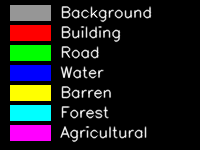

TAKING SAMPLE 1 AT EPOCH 0:
visualizing source image(urban), target image(rural) and mixed image from classes ['Forest', 'Agricultural', 'Water', 'Barren']:


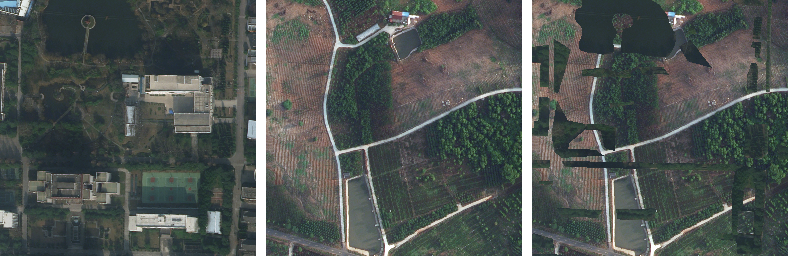

visualizing source labels(urban), target pseudo-labels(rural) and mixed labels from classes ['Forest', 'Agricultural', 'Water', 'Barren']:


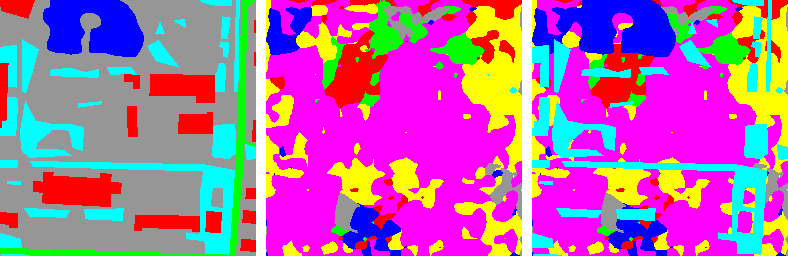

DBGP -- new lambda (epoch0|iter-2):	0.396
DBGP -- new lambda (epoch0|iter-4):	0.390
DBGP -- new lambda (epoch0|iter-6):	0.342
TRAINING RESULTS (@epoch=1): mean Loss = 7.285 | mean-IoU = 0.147
VALIDATION RESULTS (@epoch=1): mean Loss = 4.914 | mean-IoU = 0.120
Class-wise IoUs:
Class 0 (Background): IoU = 0.395
Class 1 (Building): IoU = 0.108
Class 2 (Road): IoU = 0.075
Class 3 (Water): IoU = 0.119
Class 4 (Barren): IoU = 0.027
Class 5 (Forest): IoU = 0.066
Class 6 (Agricultural): IoU = 0.047
Saving Model to saved_models/PIDNet_DACS.pth...
Done!
TAKING SAMPLE 1 AT EPOCH 1:
visualizing source image(urban), target image(rural) and mixed image from classes ['Forest', 'Background', 'Barren']:


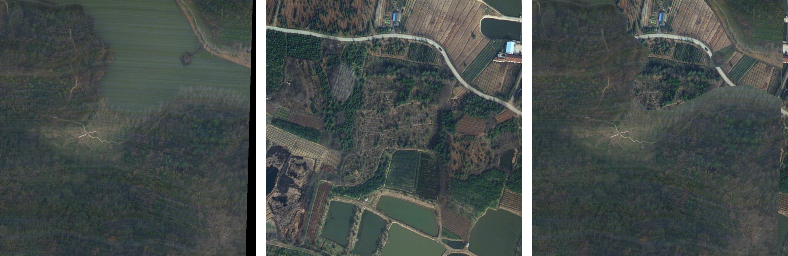

visualizing source labels(urban), target pseudo-labels(rural) and mixed labels from classes ['Forest', 'Background', 'Barren']:


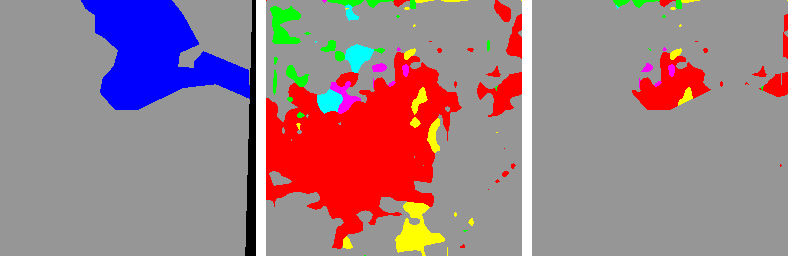

DBGP -- new lambda (epoch1|iter-2):	0.049
DBGP -- new lambda (epoch1|iter-4):	0.072
DBGP -- new lambda (epoch1|iter-6):	0.094
TRAINING RESULTS (@epoch=2): mean Loss = 3.775 | mean-IoU = 0.211
VALIDATION RESULTS (@epoch=2): mean Loss = 4.721 | mean-IoU = 0.144
Class-wise IoUs:
Class 0 (Background): IoU = 0.410
Class 1 (Building): IoU = 0.172
Class 2 (Road): IoU = 0.138
Class 3 (Water): IoU = 0.187
Class 4 (Barren): IoU = 0.032
Class 5 (Forest): IoU = 0.052
Class 6 (Agricultural): IoU = 0.016
Saving Model to saved_models/PIDNet_DACS.pth...
Done!
TAKING SAMPLE 1 AT EPOCH 2:
visualizing source image(urban), target image(rural) and mixed image from classes ['Water', 'Building', 'Forest', 'Background']:


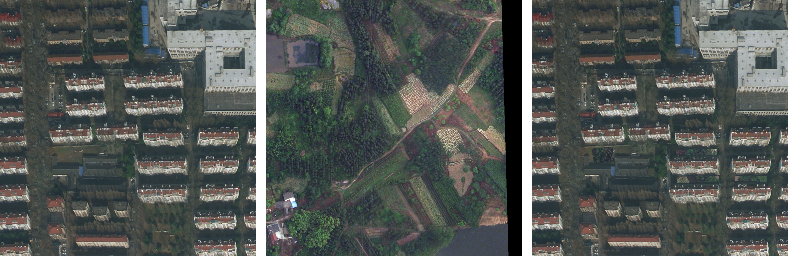

visualizing source labels(urban), target pseudo-labels(rural) and mixed labels from classes ['Water', 'Building', 'Forest', 'Background']:


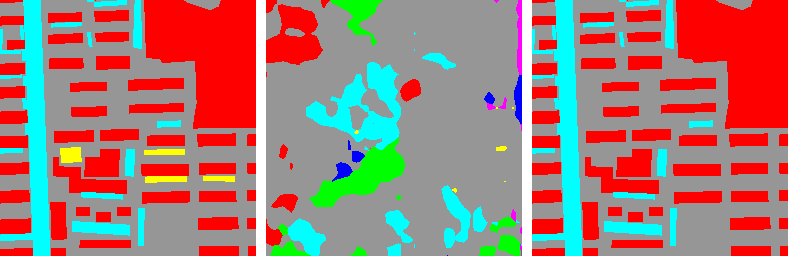

DBGP -- new lambda (epoch2|iter-2):	0.043
DBGP -- new lambda (epoch2|iter-4):	0.032
DBGP -- new lambda (epoch2|iter-6):	0.022
TRAINING RESULTS (@epoch=3): mean Loss = 3.469 | mean-IoU = 0.261
VALIDATION RESULTS (@epoch=3): mean Loss = 4.115 | mean-IoU = 0.154
Class-wise IoUs:
Class 0 (Background): IoU = 0.438
Class 1 (Building): IoU = 0.172
Class 2 (Road): IoU = 0.151
Class 3 (Water): IoU = 0.219
Class 4 (Barren): IoU = 0.035
Class 5 (Forest): IoU = 0.047
Class 6 (Agricultural): IoU = 0.014
Saving Model to saved_models/PIDNet_DACS.pth...
Done!
TAKING SAMPLE 1 AT EPOCH 3:
visualizing source image(urban), target image(rural) and mixed image from classes ['Forest', 'Barren', 'Background', 'Agricultural']:


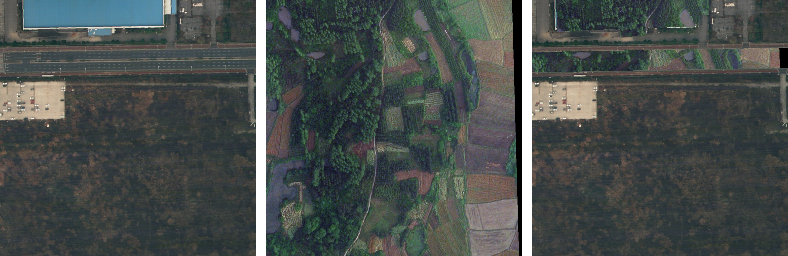

visualizing source labels(urban), target pseudo-labels(rural) and mixed labels from classes ['Forest', 'Barren', 'Background', 'Agricultural']:


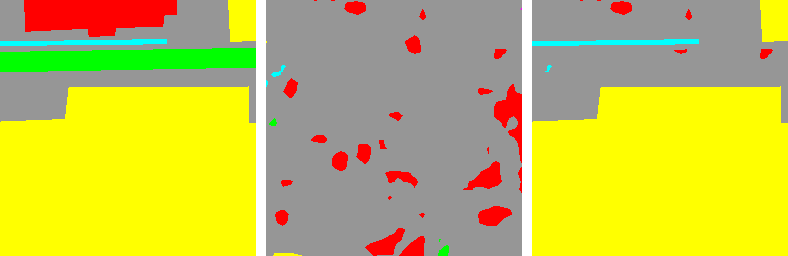

DBGP -- new lambda (epoch3|iter-2):	0.051
DBGP -- new lambda (epoch3|iter-4):	0.065
DBGP -- new lambda (epoch3|iter-6):	0.042
TRAINING RESULTS (@epoch=4): mean Loss = 3.416 | mean-IoU = 0.262
VALIDATION RESULTS (@epoch=4): mean Loss = 4.114 | mean-IoU = 0.156
Class-wise IoUs:
Class 0 (Background): IoU = 0.419
Class 1 (Building): IoU = 0.233
Class 2 (Road): IoU = 0.169
Class 3 (Water): IoU = 0.155
Class 4 (Barren): IoU = 0.019
Class 5 (Forest): IoU = 0.086
Class 6 (Agricultural): IoU = 0.008
Saving Model to saved_models/PIDNet_DACS.pth...
Done!
TAKING SAMPLE 1 AT EPOCH 4:
visualizing source image(urban), target image(rural) and mixed image from classes ['Background', 'Building', 'Agricultural']:


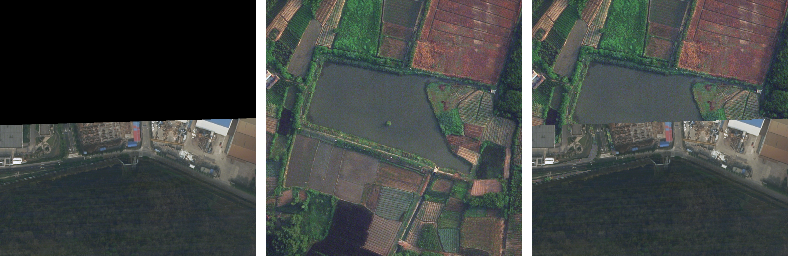

visualizing source labels(urban), target pseudo-labels(rural) and mixed labels from classes ['Background', 'Building', 'Agricultural']:


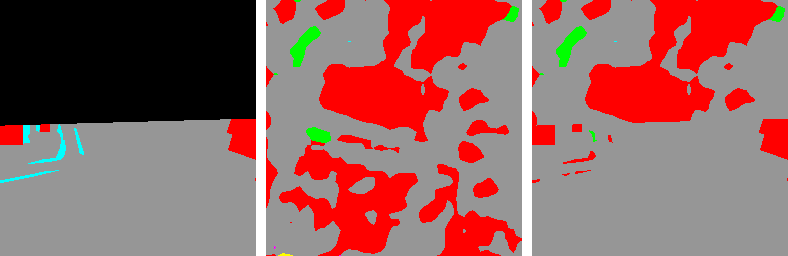

DBGP -- new lambda (epoch4|iter-2):	0.056
DBGP -- new lambda (epoch4|iter-4):	0.066
DBGP -- new lambda (epoch4|iter-6):	0.073
TRAINING RESULTS (@epoch=5): mean Loss = 3.367 | mean-IoU = 0.282
VALIDATION RESULTS (@epoch=5): mean Loss = 3.974 | mean-IoU = 0.188
Class-wise IoUs:
Class 0 (Background): IoU = 0.447
Class 1 (Building): IoU = 0.186
Class 2 (Road): IoU = 0.161
Class 3 (Water): IoU = 0.350
Class 4 (Barren): IoU = 0.026
Class 5 (Forest): IoU = 0.132
Class 6 (Agricultural): IoU = 0.016
Saving Model to saved_models/PIDNet_DACS.pth...
Done!
TAKING SAMPLE 1 AT EPOCH 5:
visualizing source image(urban), target image(rural) and mixed image from classes ['Barren', 'Background', 'Building']:


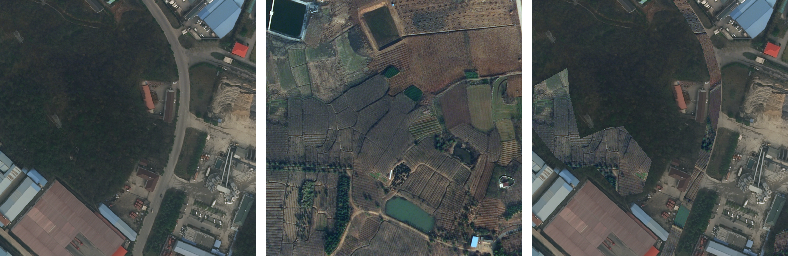

visualizing source labels(urban), target pseudo-labels(rural) and mixed labels from classes ['Barren', 'Background', 'Building']:


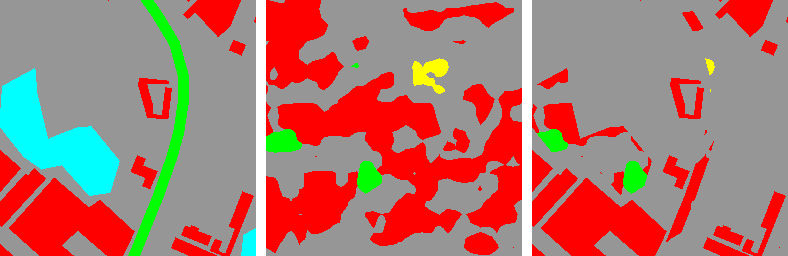

DBGP -- new lambda (epoch5|iter-2):	0.043
DBGP -- new lambda (epoch5|iter-4):	0.053
DBGP -- new lambda (epoch5|iter-6):	0.040
TRAINING RESULTS (@epoch=6): mean Loss = 3.152 | mean-IoU = 0.307
VALIDATION RESULTS (@epoch=6): mean Loss = 3.817 | mean-IoU = 0.188
Class-wise IoUs:
Class 0 (Background): IoU = 0.440
Class 1 (Building): IoU = 0.159
Class 2 (Road): IoU = 0.174
Class 3 (Water): IoU = 0.322
Class 4 (Barren): IoU = 0.033
Class 5 (Forest): IoU = 0.140
Class 6 (Agricultural): IoU = 0.047
TAKING SAMPLE 1 AT EPOCH 6:
visualizing source image(urban), target image(rural) and mixed image from classes ['Building', 'Forest', 'Road']:


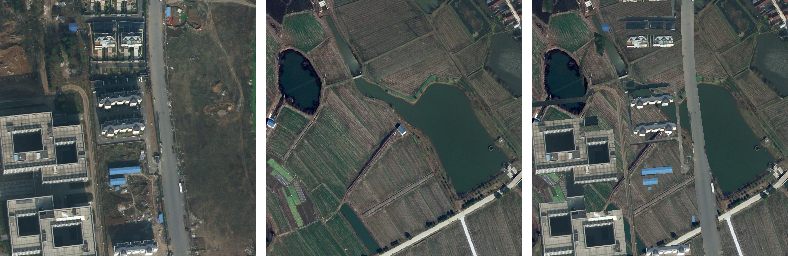

visualizing source labels(urban), target pseudo-labels(rural) and mixed labels from classes ['Building', 'Forest', 'Road']:


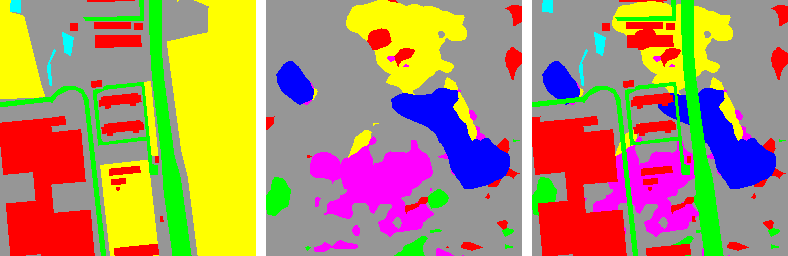

DBGP -- new lambda (epoch6|iter-2):	0.030
DBGP -- new lambda (epoch6|iter-4):	0.035
DBGP -- new lambda (epoch6|iter-6):	0.019
TRAINING RESULTS (@epoch=7): mean Loss = 3.134 | mean-IoU = 0.317
VALIDATION RESULTS (@epoch=7): mean Loss = 4.305 | mean-IoU = 0.204
Class-wise IoUs:
Class 0 (Background): IoU = 0.436
Class 1 (Building): IoU = 0.210
Class 2 (Road): IoU = 0.151
Class 3 (Water): IoU = 0.356
Class 4 (Barren): IoU = 0.040
Class 5 (Forest): IoU = 0.180
Class 6 (Agricultural): IoU = 0.055
Saving Model to saved_models/PIDNet_DACS.pth...
Done!
TAKING SAMPLE 1 AT EPOCH 7:
visualizing source image(urban), target image(rural) and mixed image from classes ['Building', 'Road', 'Forest', 'Barren']:


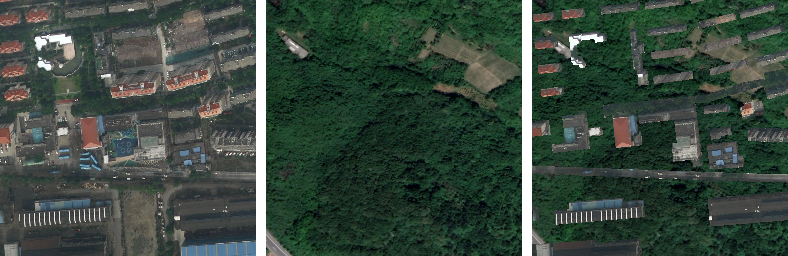

visualizing source labels(urban), target pseudo-labels(rural) and mixed labels from classes ['Building', 'Road', 'Forest', 'Barren']:


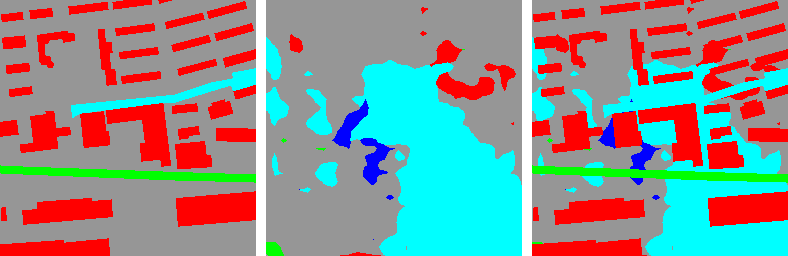

DBGP -- new lambda (epoch7|iter-2):	0.044
DBGP -- new lambda (epoch7|iter-4):	0.042
DBGP -- new lambda (epoch7|iter-6):	0.045
TRAINING RESULTS (@epoch=8): mean Loss = 3.106 | mean-IoU = 0.331


KeyboardInterrupt: 

In [103]:
import warnings
from torch.backends import cudnn

warnings.filterwarnings('ignore')
cudnn.benchmark
CUDA_LAUNCH_BLOCKING=1

model = load_model_weights(model,PIDNET_PRETRAIN_WEIGHTS_PATH).to(DEVICE)

iterPerEpoch = len(urban_train_dataloader_augmented)

best_IoU = 0

IMG_SAMPLES = (1,)
LAMBDA_PRINT_ITERS = (2,4,6)

visualize_colormap_legend()

for epoch in range(NUM_EPOCHS):
    model.train()
    epoch_loss = 0
    iou_meter = IoUMeter()

    td_iter = iter(rural_train_dataloader) # target domain iter

    for i, (source_inputs, source_labels, source_edges) in enumerate(urban_train_dataloader_augmented):
        optimizer_fn.zero_grad()

        # ---- gets Xs(+edges),Ys
        source_inputs = source_inputs.to(DEVICE)
        source_labels = source_labels.long().to(DEVICE)
        source_edges = source_edges.float().to(DEVICE)

        # ---- output size information
        h, w = source_labels.size(1), source_labels.size(2)

        # ---- gets Xt
        try:
            batch = next(td_iter)
            if batch[0].shape[0] != BATCH_SIZE:
                batch = next(td_iter)
        except:
            td_iter = iter(rural_train_dataloader) # restart
            batch = next(td_iter)

        target_inputs,_ = batch # discard target labels to perform as DA is UNSUPERVISED
        target_inputs = target_inputs.to(DEVICE)
        target_outputs = model(target_inputs)

        # interpolates the outputs
        th, tw = target_outputs[0].size(2), target_outputs[0].size(3)
        if th != h or tw != w:
          for j in range(len(target_outputs)):
            target_outputs[j] = F.interpolate(target_outputs[j], size=(h, w), mode='bilinear', align_corners=True)

        # ---- Calculate confidence for pseudo-labeling
        #PIXEL_CONFIDENCE_THRESHOLD = MIN_PX_THRSHLD + (MAX_PX_THRSHLD-MIN_PX_THRSHLD)*epoch/20
        LAMBDA = getConfidence(target_outputs[1],PIXEL_CONFIDENCE_THRESHOLD)
        #LAMBDA = LAMBDA_MIN + LAMBDA*(LAMBDA_MAX-LAMBDA_MIN)
        if i in LAMBDA_PRINT_ITERS:
          dbgp(f"new lambda (epoch{epoch}|iter-{i})", f"{LAMBDA:.3f}")

        # ---- get Y't
        _,target_pseudo_labels = torch.max(target_outputs[1].data, 1)

        # ---- virtually creates (Xm,Ym) from (Xs,Ys) and (Xt,Y't)
        mixed_inputs, mixed_labels, sel_classes = DACS_mix_batches(source_inputs,source_labels,target_inputs,target_pseudo_labels)
        if i in IMG_SAMPLES:
          print(f"{Fore.BLACK}{Back.YELLOW}TAKING SAMPLE {i} AT EPOCH {epoch}:{Style.RESET_ALL}")
          classes_names = [f"{CATEGORY_MAP[i]}" for i in sel_classes.cpu().numpy()]
          print(f"visualizing source image(urban), target image(rural) and mixed image from classes {classes_names}:")
          visualize_tensors([source_inputs[0],target_inputs[0],mixed_inputs[0]])
          print(f"visualizing source labels(urban), target pseudo-labels(rural) and mixed labels from classes {classes_names}:")
          visualize_colormask_tensor([source_labels[0],target_pseudo_labels[0],mixed_labels[0]])

        # feeds in the model with both Xs and Xm
        source_outputs = model(source_inputs)
        mixed_outputs = model(mixed_inputs)

        # check for interpolation
        soh, sow = source_outputs[0].size(2), source_outputs[0].size(3)
        if soh != h or sow != w:
          for j in range(len(source_outputs)):
            source_outputs[j] = F.interpolate(source_outputs[j], size=(h, w), mode='bilinear', align_corners=True)
        moh, mow = mixed_outputs[0].size(2), mixed_outputs[0].size(3)
        if moh != h or mow != w:
          for j in range(len(mixed_outputs)):
            mixed_outputs[j] = F.interpolate(mixed_outputs[j], size=(h, w), mode='bilinear', align_corners=True)

        # compute loss
        source_loss = sloss_fn(source_outputs, source_labels, source_edges)
        mixed_loss = mloss_fn(mixed_outputs, mixed_labels)
        loss = source_loss + LAMBDA*mixed_loss

        # backward loss and optimizer step
        loss.backward()
        optimizer_fn.step()

        # compute the training accuracy
        _, source_predicted = torch.max(source_outputs[1].data, 1)
        _, mixed_predicted = torch.max(mixed_outputs[1].data, 1)

        iou_meter.addCouple(source_predicted,source_labels)
        iou_meter.addCouple(mixed_predicted,mixed_labels)

        step_loss = loss.data.item()
        epoch_loss += step_loss

    # FINAL EPOCH-WISE COMPUTATIONS
    avg_loss = epoch_loss/iterPerEpoch
    stat_plot(avg_loss,iou_meter,mode=StatPlotMode.TRAINING,epoch=epoch)

    if validate:
        model.eval()
        val_loss = 0
        iterPerVal = len(rural_val_dataloader)
        iou_meter = IoUMeter()
        for j, (inputs, labels, edges) in enumerate(rural_val_dataloader):

            # sends data to GPU
            inputs = inputs.to(DEVICE)
            labels = labels.long().to(device=DEVICE)
            edges = edges.float().to(DEVICE)

            # feeds in the model
            outputs = model(inputs)

            # check for interpolation
            h, w = labels.size(1), labels.size(2)
            ph, pw = outputs[0].size(2), outputs[0].size(3)
            if ph != h or pw != w:
              for l in range(len(outputs)):
                outputs[l] = F.interpolate(outputs[l], size=(h, w), mode='bilinear', align_corners=True)

            # compute loss
            loss = sloss_fn(outputs, labels, edges)

            # compute the training accuracy
            _, predicted = torch.max(outputs[1].data, 1)

            iou_meter.addCouple(predicted,labels)

            step_loss = loss.data.item()
            val_loss += step_loss


        # FINAL EPOCH-WISE COMPUTATIONS
        avg_loss = val_loss/iterPerVal
        mean_IoU = iou_meter.getTotal()
        stat_plot(avg_loss,iou_meter,mode=StatPlotMode.VALIDATION,epoch=epoch)

        if mean_IoU > best_IoU:
            best_IoU = mean_IoU
            save_model_weights(model,weights_path)
        # END OF VALIDATION

optim_scheduler.step()
# END OF TRAINING


#### Testing

In [ ]:
# TESTING ON BEST WEIGHTS
model = load_model_weights(model,weights_path).to(DEVICE)
model.eval()
val_loss = 0
iterPerVal = len(rural_val_dataloader)
iou_meter = IoUMeter()
for j, (inputs, targets, edges) in enumerate(rural_val_dataloader):

    # sends data to GPU
    inputs = inputs.to(DEVICE)
    labels = targets.long().to(device=DEVICE)
    edges = edges.float().to(DEVICE)

    # feeds in the model
    outputs = model(inputs)

    # check for interpolation
    h, w = labels.size(1), labels.size(2)
    ph, pw = outputs[0].size(2), outputs[0].size(3)
    if ph != h or pw != w:
      for l in range(len(outputs)):
        outputs[l] = F.interpolate(outputs[l], size=(h, w), mode='bilinear', align_corners=True)

    # compute loss
    loss = sloss_fn(outputs, labels)


    # compute the training accuracy
    _, predicted = torch.max(outputs[1].data, 1)

    iou_meter.addCouple(predicted,labels)

    step_loss = loss.data.item()
    val_loss += step_loss


# FINAL EPOCH-WISE COMPUTATIONS
avg_loss = val_loss/iterPerVal
stat_plot(avg_loss,iou_meter,mode=StatPlotMode.TESTING)
# END OF TESTING

TEST RESULTS on VALIDATION SET: mean Loss = 2.643 | mean-IoU = 0.239
Class-wise IoUs:
Class 0 (Background): IoU = 0.484
Class 1 (Building): IoU = 0.240
Class 2 (Road): IoU = 0.196
Class 3 (Water): IoU = 0.401
Class 4 (Barren): IoU = 0.034
Class 5 (Forest): IoU = 0.057
Class 6 (Agricultural): IoU = 0.259


## 5. Extension: More Losses

Here we explored the possibility of adopting difference loss functions and their efficacy in UDA tasks:

In [104]:
BEST_TRF_INDEX = 0

### Definition of new losses

Ohem Loss:

In [105]:
from PIDNet.utils.criterion import OhemCrossEntropy

Focal Loss:

In [106]:
from PIDNet.configs import config as PIDNet_cfg

class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, ignore_label=-1,weight=None):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.ignore_label = ignore_label
        self.criterion = nn.CrossEntropyLoss(
            weight=weight,
            ignore_index=ignore_label
        )

    def _forward(self, score, target):
      logpt = -self.criterion(score, target) # CE
      pt = torch.exp(logpt)
      fl = - self.alpha * ((1 - pt).pow(self.gamma)) * logpt
      return fl.mean()

    def forward(self, score, target):
        if not isinstance(score, list):
            raise ValueError("score is expected to be a list of tensors")

        balance_weights = PIDNet_cfg.LOSS.BALANCE_WEIGHTS

        if len(balance_weights) == len(score):
            return sum([w * self._forward(x, target) for (w, x) in zip(balance_weights, score)])
        elif len(score) == 1:
            return self._forward(score[0], target)
        else:
            raise ValueError("lengths of prediction and target are not identical!")

Dice Loss:

In [107]:
class DiceLoss(nn.Module):
    def __init__(self, smooth=1.0, reduction="mean", ignore_label=-1):
        super(DiceLoss, self).__init__()
        self.ignore_label = ignore_label
        self.smooth = smooth
        self.reduction = reduction

    def _forward(self,logits,target):
      # Apply softmax to logits to get probabilities
      probs = F.softmax(logits, dim=1)  # Shape: (N, C, H, W)

      # convert target to one-hot
      if self.ignore_label is not None:
        # handle ignored indexes
        ignore_mask = (target == self.ignore_label)
        target_mask = (target != self.ignore_label)
        target[ignore_mask] = 0

      target = F.one_hot(target, num_classes=NUM_CLASSES)  # Convert to (N, H, W, C)
      target = target.permute(0, 3, 1, 2).float()  # Convert to (N, C, H, W)

      # Handle ignore_label by masking
      if self.ignore_label is not None:
          #mask = (target.sum(dim=1) != self.ignore_label).unsqueeze(1)  # Shape: (N, 1, H, W)
          target_mask = target_mask.unsqueeze(1).repeat(1,7,1,1)
          probs = probs * target_mask
          target = target * target_mask

      # Compute intersection and union
      intersection = (probs * target).sum(dim=(2, 3))  # Sum over H, W
      union = (probs + target).sum(dim=(2, 3))  # Sum over H, W

      # Compute Dice coefficient
      dice_coeff = (2.0 * intersection + self.smooth) / (union + self.smooth)

      # Compute Dice loss
      dice_loss = 1.0 - dice_coeff  # Shape: (N, C)

      # Reduction
      if self.reduction == 'mean':
          return dice_loss.mean()
      elif self.reduction == 'sum':
          return dice_loss.sum()
      else:  # 'none'
          return dice_loss

    def forward(self, score, target):
        if not isinstance(score, list):
            raise ValueError("score is expected to be a list of tensors")

        balance_weights = PIDNet_cfg.LOSS.BALANCE_WEIGHTS

        if len(balance_weights) == len(score):
            return sum([w * self._forward(x, target) for (w, x) in zip(balance_weights, score)])
        elif len(score) == 1:
            return self._forward(score[0], target)
        else:
            raise ValueError("lengths of prediction and target are not identical!")

### model, datasets and dataloaders

In [108]:
best_trf = train_transform_augmentations[BEST_TRF_INDEX]
#max_iou = test_results[BEST_TRF_INDEX]
#print(f"with cross entropy best augmentation led to mIoU={max_iou:.3f} with domain shift.")

In [109]:
rural_val = LoveDA(VAL_PATH, DataType.RURAL, transforms=base_transform)
rural_val_dataloader = DataLoader(rural_val, shuffle=False, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, drop_last=True)
# dataset and dataloaders change at each iter to use different augmentation chains
urban_train_augmented = LoveDA(TRAIN_PATH, DataType.URBAN, transforms=best_trf, with_edges=True) # change transformation in each run
urban_train_dataloader_augmented = DataLoader(urban_train_augmented, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, drop_last=True)

In [115]:
model = PIDNet(m=2, n=3, num_classes=NUM_CLASSES, planes=32, ppm_planes=96, head_planes=128, augment=True)
model = load_model_weights(model,PIDNET_PRETRAIN_WEIGHTS_PATH)
models_names = ["PIDNet_DS_aug1_OhemLoss","PIDNet_DS_aug1_FocalLoss","PIDNet_DS_aug1_DiceLoss"]
weights_paths = [get_final_weights_path(name) for name in models_names]
gdown_links = ["https://drive.google.com/uc?id=1bVgddU0p9RV4i-zyn-xryaNliuabYExe", "https://drive.google.com/uc?id=1QbqGoXljPrxTBgn6aPHHNOro_vuPoIYL","https://drive.google.com/uc?id=1Qa9NaJdLz3q_mScPlehfXH9qjSSzboxo"]
if CONFIG_FINAL_WEIGHTS:
  for i,gl in enumerate(gdown_links):
    if gl is None:
      print(f"No weight to donwload for model {models_names[i]}")
    else:
      gdown.download(gl, weights_paths[i], quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1bVgddU0p9RV4i-zyn-xryaNliuabYExe
From (redirected): https://drive.google.com/uc?id=1bVgddU0p9RV4i-zyn-xryaNliuabYExe&confirm=t&uuid=ac47630e-05a1-413e-9f53-f59f9a2cfaca
To: /content/saved_models/PIDNet_DS_aug1_OhemLoss.pth
100%|██████████| 31.1M/31.1M [00:01<00:00, 24.0MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1QbqGoXljPrxTBgn6aPHHNOro_vuPoIYL
From (redirected): https://drive.google.com/uc?id=1QbqGoXljPrxTBgn6aPHHNOro_vuPoIYL&confirm=t&uuid=f262b637-50c0-420d-92f3-985e79cd84a2
To: /content/saved_models/PIDNet_DS_aug1_FocalLoss.pth
100%|██████████| 31.1M/31.1M [00:00<00:00, 44.9MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1Qa9NaJdLz3q_mScPlehfXH9qjSSzboxo
From (redirected): https://drive.google.com/uc?id=1Qa9NaJdLz3q_mScPlehfXH9qjSSzboxo&confirm=t&uuid=1fe62c29-c711-471a-87ac-25ce1c27e7c6
To: /content/saved_models/PIDNet_DS_aug1_DiceLoss.pth
100%|██████████| 31.1M/31.1M [00

### General Hyperparams conf

In [111]:
LR = 2e-4               # The initial Learning Rate
WEIGHT_DECAY = 5e-4     # Regularization, you can keep this at the default
NUM_EPOCHS = 20         # Total number of training epochs (iterations over dataset)
STEP_SIZE = [10, 15]    # How many epochs before decreasing learning rate (if using a step-down policy)
GAMMA = 0.1

# enable validation during training
validate = True

### 1. Ohem Loss

In [66]:
model = load_model_weights(model,PIDNET_PRETRAIN_WEIGHTS_PATH)
model_name, weights_path = models_names[0], weights_paths[0]

In [67]:
# loss function
loss_fn = PIDNetLoss(OhemCrossEntropy)
model = model.to(DEVICE) # switch to GPU

#Opt
trainable_params = [p for p in model.parameters() if p.requires_grad]
optimizer_fn = optim.Adam(trainable_params, lr=LR, weight_decay=WEIGHT_DECAY, eps=1e-4)

#Scheduler
optim_scheduler = optim.lr_scheduler.MultiStepLR(optimizer_fn, milestones=STEP_SIZE, gamma=GAMMA)

In [68]:
import warnings

from torch.backends import cudnn
warnings.filterwarnings('ignore')

iterPerEpoch = len(urban_train_dataloader_augmented)

cudnn.benchmark
CUDA_LAUNCH_BLOCKING=1

best_IoU = 0

for epoch in range(NUM_EPOCHS):
    model.train()
    epoch_loss = 0
    iou_meter = IoUMeter()

    for i, (inputs, labels, edges) in enumerate(urban_train_dataloader_augmented):
        optimizer_fn.zero_grad()

        # send inputs to gpu
        inputs = inputs.to(DEVICE)
        labels = labels.long().to(DEVICE)
        edges = edges.float().to(DEVICE)

        # feeds in the model
        outputs = model(inputs)

        h, w = labels.size(1), labels.size(2)
        ph, pw = outputs[0].size(2), outputs[0].size(3)
        if ph != h or pw != w:
          for i in range(len(outputs)):
            outputs[i] = F.interpolate(outputs[i], size=(h, w), mode='bilinear', align_corners=True)

        # compute loss
        loss = loss_fn(outputs,labels,edges)

        # backward loss and optimizer step
        loss.backward()
        optimizer_fn.step()

        #compute the training accuracy
        _, predicted = torch.max(outputs[1].data, 1)

        iou_meter.addCouple(predicted,labels)

        step_loss = loss.data.item()
        epoch_loss += step_loss

    # FINAL EPOCH-WISE COMPUTATIONS
    avg_loss = epoch_loss/iterPerEpoch
    stat_plot(avg_loss,iou_meter,mode=StatPlotMode.TRAINING,epoch=epoch)

    if validate:
        model.eval()
        val_loss = 0
        iterPerVal = len(rural_val_dataloader)
        iou_meter = IoUMeter()
        for j, (inputs, labels, edges) in enumerate(rural_val_dataloader):

            # sends data to GPU
            inputs = inputs.to(DEVICE)
            labels = labels.long().to(device=DEVICE)
            edges = edges.float().to(device=DEVICE)



            # feeds in model
            outputs = model(inputs)
            h, w = labels.size(1), labels.size(2)
            ph, pw = outputs[0].size(2), outputs[0].size(3)
            if ph != h or pw != w:
              for i in range(len(outputs)):
                outputs[i] = F.interpolate(outputs[i], size=(h, w), mode='bilinear', align_corners=True)


            # compute loss
            loss = loss_fn(outputs,labels,edges)

            # compute the training accuracy
            _, predicted = torch.max(outputs[1].data, 1)

            iou_meter.addCouple(predicted,labels)

            step_loss = loss.data.item()
            val_loss += step_loss


        # FINAL EPOCH-WISE COMPUTATIONS
        avg_loss = val_loss/iterPerVal
        mean_IoU = iou_meter.getTotal()

        stat_plot(avg_loss,iou_meter,mode= StatPlotMode.VALIDATION,epoch=epoch)

        if mean_IoU > best_IoU:
            best_IoU = mean_IoU
            save_model_weights(model,weights_path)
        # END OF VALIDATION

    optim_scheduler.step()

TRAINING RESULTS (@epoch=1): mean Loss = 8.194 | mean-IoU = 0.118
VALIDATION RESULTS (@epoch=1): mean Loss = 4.597 | mean-IoU = 0.115
Class-wise IoUs:
Class 0 (Background): IoU = 0.355
Class 1 (Building): IoU = 0.122
Class 2 (Road): IoU = 0.054
Class 3 (Water): IoU = 0.139
Class 4 (Barren): IoU = 0.015
Class 5 (Forest): IoU = 0.058
Class 6 (Agricultural): IoU = 0.061
Saving Model to saved_models/PIDNet_DS_aug1_OhemLoss.pth...
Done!
TRAINING RESULTS (@epoch=2): mean Loss = 3.923 | mean-IoU = 0.197
VALIDATION RESULTS (@epoch=2): mean Loss = 3.865 | mean-IoU = 0.150
Class-wise IoUs:
Class 0 (Background): IoU = 0.436
Class 1 (Building): IoU = 0.184
Class 2 (Road): IoU = 0.103
Class 3 (Water): IoU = 0.137
Class 4 (Barren): IoU = 0.015
Class 5 (Forest): IoU = 0.069
Class 6 (Agricultural): IoU = 0.107
Saving Model to saved_models/PIDNet_DS_aug1_OhemLoss.pth...
Done!
TRAINING RESULTS (@epoch=3): mean Loss = 3.435 | mean-IoU = 0.261
VALIDATION RESULTS (@epoch=3): mean Loss = 3.765 | mean-IoU = 

### 2. Focal Loss

In [112]:
model = load_model_weights(model,PIDNET_PRETRAIN_WEIGHTS_PATH)
model_name, weights_path = models_names[1], weights_paths[1]

In [113]:
# loss function
loss_fn = PIDNetLoss(FocalLoss)
model = model.to(DEVICE) # switch to GPU

#Opt
trainable_params = [p for p in model.parameters() if p.requires_grad]
optimizer_fn = optim.Adam(trainable_params, lr=LR, weight_decay=WEIGHT_DECAY, eps=1e-4)

#Scheduler
optim_scheduler = optim.lr_scheduler.MultiStepLR(optimizer_fn, milestones=STEP_SIZE, gamma=GAMMA)

In [114]:
import warnings

from torch.backends import cudnn
warnings.filterwarnings('ignore')

iterPerEpoch = len(urban_train_dataloader_augmented)

cudnn.benchmark
CUDA_LAUNCH_BLOCKING=1

best_IoU = 0

for epoch in range(NUM_EPOCHS):
    model.train()
    epoch_loss = 0
    iou_meter = IoUMeter()

    for i, (inputs, labels, edges) in enumerate(urban_train_dataloader_augmented):
        optimizer_fn.zero_grad()

        # send inputs to gpu
        inputs = inputs.to(DEVICE)
        labels = labels.long().to(DEVICE)
        edges = edges.float().to(DEVICE)

        # feeds in the model
        outputs = model(inputs)

        h, w = labels.size(1), labels.size(2)
        ph, pw = outputs[0].size(2), outputs[0].size(3)
        if ph != h or pw != w:
          for i in range(len(outputs)):
            outputs[i] = F.interpolate(outputs[i], size=(h, w), mode='bilinear', align_corners=True)

        # compute loss
        loss = loss_fn(outputs,labels,edges)

        # backward loss and optimizer step
        loss.backward()
        optimizer_fn.step()

        #compute the training accuracy
        _, predicted = torch.max(outputs[1].data, 1)

        iou_meter.addCouple(predicted,labels)

        step_loss = loss.data.item()
        epoch_loss += step_loss

    # FINAL EPOCH-WISE COMPUTATIONS
    avg_loss = epoch_loss/iterPerEpoch
    stat_plot(avg_loss,iou_meter,mode=StatPlotMode.TRAINING,epoch=epoch)

    if validate:
        model.eval()
        val_loss = 0
        iterPerVal = len(rural_val_dataloader)
        iou_meter = IoUMeter()
        for j, (inputs, labels, edges) in enumerate(rural_val_dataloader):

            # sends data to GPU
            inputs = inputs.to(DEVICE)
            labels = labels.long().to(device=DEVICE)
            edges = edges.float().to(device=DEVICE)



            # feeds in model
            outputs = model(inputs)
            h, w = labels.size(1), labels.size(2)
            ph, pw = outputs[0].size(2), outputs[0].size(3)
            if ph != h or pw != w:
              for i in range(len(outputs)):
                outputs[i] = F.interpolate(outputs[i], size=(h, w), mode='bilinear', align_corners=True)


            # compute loss
            loss = loss_fn(outputs,labels,edges)

            # compute the training accuracy
            _, predicted = torch.max(outputs[1].data, 1)

            iou_meter.addCouple(predicted,labels)

            step_loss = loss.data.item()
            val_loss += step_loss


        # FINAL EPOCH-WISE COMPUTATIONS
        avg_loss = val_loss/iterPerVal
        mean_IoU = iou_meter.getTotal()

        stat_plot(avg_loss,iou_meter,mode= StatPlotMode.VALIDATION,epoch=epoch)

        if mean_IoU > best_IoU:
            best_IoU = mean_IoU
            save_model_weights(model,weights_path)
        # END OF VALIDATION

    optim_scheduler.step()

TRAINING RESULTS (@epoch=1): mean Loss = 8.296 | mean-IoU = 0.120
VALIDATION RESULTS (@epoch=1): mean Loss = 4.830 | mean-IoU = 0.112
Class-wise IoUs:
Class 0 (Background): IoU = 0.370
Class 1 (Building): IoU = 0.157
Class 2 (Road): IoU = 0.046
Class 3 (Water): IoU = 0.091
Class 4 (Barren): IoU = 0.023
Class 5 (Forest): IoU = 0.057
Class 6 (Agricultural): IoU = 0.040
Saving Model to saved_models/PIDNet_DS_aug1_FocalLoss.pth...
Done!
TRAINING RESULTS (@epoch=2): mean Loss = 3.214 | mean-IoU = 0.188
VALIDATION RESULTS (@epoch=2): mean Loss = 3.750 | mean-IoU = 0.131
Class-wise IoUs:
Class 0 (Background): IoU = 0.386
Class 1 (Building): IoU = 0.240
Class 2 (Road): IoU = 0.084
Class 3 (Water): IoU = 0.129
Class 4 (Barren): IoU = 0.015
Class 5 (Forest): IoU = 0.056
Class 6 (Agricultural): IoU = 0.010
Saving Model to saved_models/PIDNet_DS_aug1_FocalLoss.pth...
Done!
TRAINING RESULTS (@epoch=3): mean Loss = 3.032 | mean-IoU = 0.223
VALIDATION RESULTS (@epoch=3): mean Loss = 3.834 | mean-IoU 

### 3. Dice Loss

In [48]:
model = load_model_weights(model,PIDNET_PRETRAIN_WEIGHTS_PATH)
model_name, weights_path = models_names[2], weights_paths[2]

<ipython-input-17-dfcf0b107260>:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  weights_dict = torch.load(weights_path, map_location=torch.device(DEVICE))


In [49]:
# loss function
loss_fn = PIDNetLoss(DiceLoss)
model = model.to(DEVICE) # switch to GPU

#Opt
trainable_params = [p for p in model.parameters() if p.requires_grad]
optimizer_fn = optim.Adam(trainable_params, lr=LR, weight_decay=WEIGHT_DECAY, eps=1e-4)

#Scheduler
optim_scheduler = optim.lr_scheduler.MultiStepLR(optimizer_fn, milestones=STEP_SIZE, gamma=GAMMA)

In [50]:
import warnings

from torch.backends import cudnn
warnings.filterwarnings('ignore')

iterPerEpoch = len(urban_train_dataloader_augmented)

cudnn.benchmark
CUDA_LAUNCH_BLOCKING=1

best_IoU = 0

for epoch in range(NUM_EPOCHS):
    model.train()
    epoch_loss = 0
    iou_meter = IoUMeter()

    for i, (inputs, labels, edges) in enumerate(urban_train_dataloader_augmented):
        optimizer_fn.zero_grad()

        # send inputs to gpu
        inputs = inputs.to(DEVICE)
        labels = labels.long().to(DEVICE)
        edges = edges.float().to(DEVICE)

        # feeds in the model
        outputs = model(inputs)

        h, w = labels.size(1), labels.size(2)
        ph, pw = outputs[0].size(2), outputs[0].size(3)
        if ph != h or pw != w:
          for i in range(len(outputs)):
            outputs[i] = F.interpolate(outputs[i], size=(h, w), mode='bilinear', align_corners=True)

        # compute loss
        loss = loss_fn(outputs,labels,edges)

        # backward loss and optimizer step
        loss.backward()
        optimizer_fn.step()

        #compute the training accuracy
        _, predicted = torch.max(outputs[1].data, 1)

        iou_meter.addCouple(predicted,labels)

        step_loss = loss.data.item()
        epoch_loss += step_loss

    # FINAL EPOCH-WISE COMPUTATIONS
    avg_loss = epoch_loss/iterPerEpoch
    stat_plot(avg_loss,iou_meter,mode=StatPlotMode.TRAINING,epoch=epoch)

    if validate:
        model.eval()
        val_loss = 0
        iterPerVal = len(rural_val_dataloader)
        iou_meter = IoUMeter()
        for j, (inputs, labels, edges) in enumerate(rural_val_dataloader):

            # sends data to GPU
            inputs = inputs.to(DEVICE)
            labels = labels.long().to(device=DEVICE)
            edges = edges.float().to(device=DEVICE)



            # feeds in model
            outputs = model(inputs)
            h, w = labels.size(1), labels.size(2)
            ph, pw = outputs[0].size(2), outputs[0].size(3)
            if ph != h or pw != w:
              for i in range(len(outputs)):
                outputs[i] = F.interpolate(outputs[i], size=(h, w), mode='bilinear', align_corners=True)


            # compute loss
            loss = loss_fn(outputs,labels,edges)

            # compute the training accuracy
            _, predicted = torch.max(outputs[1].data, 1)

            iou_meter.addCouple(predicted,labels)

            step_loss = loss.data.item()
            val_loss += step_loss


        # FINAL EPOCH-WISE COMPUTATIONS
        avg_loss = val_loss/iterPerVal
        mean_IoU = iou_meter.getTotal()

        stat_plot(avg_loss,iou_meter,mode= StatPlotMode.VALIDATION,epoch=epoch)

        if mean_IoU > best_IoU:
            best_IoU = mean_IoU
            save_model_weights(model,weights_path)
        # END OF VALIDATION

    optim_scheduler.step()

TRAINING RESULTS (@epoch=1): mean Loss = 4.039 | mean-IoU = 0.111
VALIDATION RESULTS (@epoch=1): mean Loss = 2.706 | mean-IoU = 0.086
Class-wise IoUs:
Class 0 (Background): IoU = 0.111
Class 1 (Building): IoU = 0.231
Class 2 (Road): IoU = 0.038
Class 3 (Water): IoU = 0.154
Class 4 (Barren): IoU = 0.039
Class 5 (Forest): IoU = 0.033
Class 6 (Agricultural): IoU = 0.000
Saving Model to saved_models/PIDNet_DS_aug1_DiceLoss.pth...
Done!
TRAINING RESULTS (@epoch=2): mean Loss = 2.741 | mean-IoU = 0.165
VALIDATION RESULTS (@epoch=2): mean Loss = 2.307 | mean-IoU = 0.105
Class-wise IoUs:
Class 0 (Background): IoU = 0.262
Class 1 (Building): IoU = 0.237
Class 2 (Road): IoU = 0.058
Class 3 (Water): IoU = 0.140
Class 4 (Barren): IoU = 0.028
Class 5 (Forest): IoU = 0.011
Class 6 (Agricultural): IoU = 0.000
Saving Model to saved_models/PIDNet_DS_aug1_DiceLoss.pth...
Done!
TRAINING RESULTS (@epoch=3): mean Loss = 2.493 | mean-IoU = 0.190
VALIDATION RESULTS (@epoch=3): mean Loss = 2.106 | mean-IoU = 